# Assignment 3: MIMIC III Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.imputation import RandomSampleImputer

In [2]:
mimic_time_data = pd.read_csv("mimicfull.csv")
mimic_time_data.head()


SUBJECT_ID                  CHARTTIME                   MEASUREMENT  \
0       18992  2124-05-15 18:51:00.000 Z                     Potassium   
1       18992  2124-05-15 18:51:00.000 Z                       Glucose   
2       18992  2124-05-15 19:00:00.000 Z      Diastolic blood pressure   
3       18992  2124-05-15 19:00:00.000 Z                   Temperature   
4       18992  2124-05-15 19:00:00.000 Z  Peripheral oxygen saturation   

     VALUENUM       LOS GENDER ETHNICITY   AGE  DIED_DURING_ICU_STAY  \
0    3.900000  104.2483      M     WHITE  40.0                     0   
1  116.000000  104.2483      M     WHITE  40.0                     0   
2   52.000000  104.2483      M     WHITE  40.0                     0   
3   36.722221  104.2483      M     WHITE  40.0                     0   
4   92.000000  104.2483      M     WHITE  40.0                     0   

                     OUTTIME  
0  2124-08-03 12:09:45.000 Z  
1  2124-08-03 12:09:45.000 Z  
2  2124-08-03 12:09:45.000 Z  
3  2124-08-03 12:09:45.000 Z  
4  2124-08-03 12:09:45.000 Z

In [3]:
mimic_time_data.shape

(27635100, 10)

The time series data extracted from the MIMIC database contains over 2.7 million observations and 10 columns. Each patient is identified by SUBJECT_ID, and CHARTTIME records when medical tests were conducted. The MEASUREMENT and VALUENUM columns capture vital signs and laboratory results. LOS represents the length of ICU stay in fractional days, while GENDER, ETHNICITY, and AGE provide demographic information. The DIED_DURING_ICU_STAY column indicates patient survival status in the ICU, and OUTTIME notes the discharge time or time of death.

In [4]:
mimic_time_data.columns = mimic_time_data.columns.str.lower()
mimic_time_data['charttime'] = pd.to_datetime(mimic_time_data['charttime'])
mimic_time_data['outtime'] = pd.to_datetime(mimic_time_data['outtime'])

Next, we filter for vital signs and laboratory test results recorded during the last 24 hours before patient discharge. If multiple records exist for a patient, we calculate the average. The results are then recorded into new columns.

In [5]:
# Filter rows within 24 hours before discharge
mimic_24hrs = mimic_time_data[(mimic_time_data['charttime'] >= mimic_time_data['outtime'] - pd.Timedelta(hours=24)) & (mimic_time_data['charttime'] <= mimic_time_data['outtime'])]

# Group by subject_id and measurement, and calculate the mean of valuenum
mimic_aggregated = mimic_24hrs.groupby(['subject_id', 'measurement']).valuenum.mean().reset_index()

# Pivot the table to create new columns for each measurement
mimic_pivoted = mimic_aggregated.pivot(index='subject_id', columns='measurement', values='valuenum').reset_index()

# Merge with the additional columns from the same subject_id
mimic_final = mimic_24hrs[['subject_id', 'age', 'gender', 'ethnicity', 'los', 'died_during_icu_stay']].drop_duplicates(subset='subject_id')
mimic = mimic_pivoted.merge(mimic_final, on='subject_id', how='left')

# Rename columns with custom names
custom_columns = {
    'Diastolic blood pressure': 'dbp',
    'Systolic blood pressure': 'sbp',
    'Mean arterial pressure': 'map',
    'Temperature': 'temp',
    'Peripheral oxygen saturation': 'spo2',
    'Heart rate': 'heart_rate',
    'Respiratory rate': 'resp_rate',
    'Albumin': 'albumin',
    'Blood urea nitrogen': 'bun',
    'Bilirubin': 'bilirubin',
    'Lactate': 'lactate',
    'Bicarbonate': 'bicarbonate',
    'Band neutrophil': 'neutrophils',
    'Chloride': 'chloride',
    'Creatinine': 'creatinine',
    'Glucose': 'glucose',
    'Hematocrit': 'hematocrit',
    'Hemoglobin': 'hemoglobin',
    'Platelet count': 'platelets',
    'Potassium': 'potassium',
    'Partial thromboplastin time': 'ptt',
    'Sodium': 'sodium',
    'White blood cells': 'wbc', 
    'died_during_icu_stay': 'death_status'
}

mimic.rename(columns=custom_columns, inplace=True)

# Display the resulting DataFrame
display(mimic.head())

subject_id  albumin  neutrophils  bicarbonate  bilirubin   bun  chloride  \
0           3      NaN          NaN         23.0        NaN  17.0      96.0   
1           6      NaN          NaN         14.0        0.3  73.0     101.0   
2           9      NaN          NaN         24.0        NaN  33.0     107.0   
3          12      2.5          NaN         23.0        7.7  29.0     100.0   
4          13      NaN          NaN         29.0        NaN  13.0     104.0   

   creatinine        dbp  glucose  ...  resp_rate      sodium         sbp  \
0         1.3  55.545455     85.0  ...  20.363636  131.500000  116.863636   
1         5.1  64.047619    118.0  ...  14.347826  130.000000  153.523810   
2         2.0  76.476190    114.0  ...  16.653846  135.666667  141.666667   
3         1.1  75.450000    130.0  ...  31.400000  135.000000  146.300000   
4         0.4  60.520000    168.5  ...  18.840000  138.000000  125.440000   

        temp   wbc   age  gender              ethnicity     los  death_status  
0  35.930556  10.5  76.0       M                  WHITE  6.0646             0  
1  36.039682   3.9  66.0       F                  WHITE  3.6729             0  
2  35.888889  11.1  41.0       M  UNKNOWN/NOT SPECIFIED  5.3231             1  
3  37.074074  30.2  72.0       M                  WHITE  7.6348             1  
4  37.687301  14.3  40.0       F                  WHITE  3.6660             0  

[5 rows x 29 columns]

In [6]:
mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18830 entries, 0 to 18829
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject_id    18830 non-null  int64  
 1   albumin       1986 non-null   float64
 2   neutrophils   710 non-null    float64
 3   bicarbonate   17441 non-null  float64
 4   bilirubin     3113 non-null   float64
 5   bun           17516 non-null  float64
 6   chloride      17491 non-null  float64
 7   creatinine    17519 non-null  float64
 8   dbp           18748 non-null  float64
 9   glucose       17516 non-null  float64
 10  heart_rate    18789 non-null  float64
 11  hematocrit    17492 non-null  float64
 12  hemoglobin    17289 non-null  float64
 13  lactate       1529 non-null   float64
 14  map           18738 non-null  float64
 15  ptt           9430 non-null   float64
 16  spo2          18693 non-null  float64
 17  platelets     17302 non-null  float64
 18  potassium     17667 non-nu

In [7]:
round(mimic.isna().mean()*100, 2)

subject_id       0.00
albumin         89.45
neutrophils     96.23
bicarbonate      7.38
bilirubin       83.47
bun              6.98
chloride         7.11
creatinine       6.96
dbp              0.44
glucose          6.98
heart_rate       0.22
hematocrit       7.11
hemoglobin       8.18
lactate         91.88
map              0.49
ptt             49.92
spo2             0.73
platelets        8.11
potassium        6.18
resp_rate        0.49
sodium           6.91
sbp              0.42
temp             0.94
wbc              8.13
age              0.00
gender           0.00
ethnicity        0.00
los              0.00
death_status     0.00
dtype: float64

The resulting dataset contains information on the last 24 hours in the ICU for individual patients, identified by unique subject_id. It includes 18,830 patients and 29 columns. All columns, except for demographics and death_status, have missing values. Neutrophils has the most missing values at 96%, followed by Lactate at 92%, Albumin at 89%, Bilirubin at 83%, and PTT at 50%.

In [8]:
mimic.head()

subject_id  albumin  neutrophils  bicarbonate  bilirubin   bun  chloride  \
0           3      NaN          NaN         23.0        NaN  17.0      96.0   
1           6      NaN          NaN         14.0        0.3  73.0     101.0   
2           9      NaN          NaN         24.0        NaN  33.0     107.0   
3          12      2.5          NaN         23.0        7.7  29.0     100.0   
4          13      NaN          NaN         29.0        NaN  13.0     104.0   

   creatinine        dbp  glucose  ...  resp_rate      sodium         sbp  \
0         1.3  55.545455     85.0  ...  20.363636  131.500000  116.863636   
1         5.1  64.047619    118.0  ...  14.347826  130.000000  153.523810   
2         2.0  76.476190    114.0  ...  16.653846  135.666667  141.666667   
3         1.1  75.450000    130.0  ...  31.400000  135.000000  146.300000   
4         0.4  60.520000    168.5  ...  18.840000  138.000000  125.440000   

        temp   wbc   age  gender              ethnicity     los  death_status  
0  35.930556  10.5  76.0       M                  WHITE  6.0646             0  
1  36.039682   3.9  66.0       F                  WHITE  3.6729             0  
2  35.888889  11.1  41.0       M  UNKNOWN/NOT SPECIFIED  5.3231             1  
3  37.074074  30.2  72.0       M                  WHITE  7.6348             1  
4  37.687301  14.3  40.0       F                  WHITE  3.6660             0  

[5 rows x 29 columns]

In [9]:
mimic = mimic.drop(columns=['subject_id'])

### Demographic features

There are three features related to demographic information: gender, ethnicity, and age. We examine the distribution of these features.

#### Gender

In [10]:
mimic["gender"].value_counts(normalize=True)

gender
M    0.559426
F    0.440574
Name: proportion, dtype: float64

The dataset is composed of 56% male patients and 44% female patients.

<Axes: xlabel='gender', ylabel='count'>

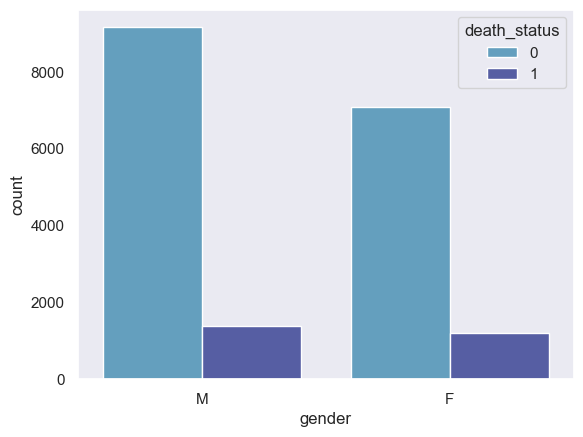

In [11]:
sns.set(style="dark", palette="icefire")
sns.countplot(mimic, x="gender", hue='death_status')

The side-by-side bar plot shows that the pattern of death status is similar for both genders, thus there is no association between the two variables.

#### Ethnicity

In [12]:
mimic.ethnicity.value_counts()

ethnicity
WHITE                                         13196
UNKNOWN/NOT SPECIFIED                          2021
BLACK/AFRICAN AMERICAN                         1306
HISPANIC OR LATINO                              450
OTHER                                           428
UNABLE TO OBTAIN                                399
ASIAN                                           282
PATIENT DECLINED TO ANSWER                      188
ASIAN - CHINESE                                  89
HISPANIC/LATINO - PUERTO RICAN                   68
BLACK/CAPE VERDEAN                               52
WHITE - RUSSIAN                                  48
MULTI RACE ETHNICITY                             37
WHITE - OTHER EUROPEAN                           28
HISPANIC/LATINO - DOMINICAN                      27
BLACK/HAITIAN                                    23
ASIAN - ASIAN INDIAN                             20
WHITE - BRAZILIAN                                20
PORTUGUESE                                       18
AS

Ethnicity comprises various groups. We will combine some due to overlaps and categorize the remaining groups as "Other".

In [13]:
def categorize_ethnicity(ethnicity):
    """Categorize ethnicity into 5 groups: White, Black, Hispanic/Latino, Asian, and Other"""
    ethnicity = ethnicity.lower()
    if 'white' in ethnicity:
        return 'White'
    elif 'black' in ethnicity or 'AFRICAN' in ethnicity:
        return 'Black'
    elif 'hispanic' in ethnicity or 'latino' in ethnicity:
        return 'Hispanic/Latino'
    elif 'asian' in ethnicity:
        return 'Asian'
    else:
        return 'Other'

In [14]:
mimic['ethnicity'] = mimic['ethnicity'].apply(categorize_ethnicity)
mimic['ethnicity'].value_counts(normalize=True)

ethnicity
White              0.706320
Other              0.165905
Black              0.074137
Hispanic/Latino    0.030377
Asian              0.023261
Name: proportion, dtype: float64

After combining similar ethnicities, the patient distribution is 71% White, 17% Other, 7% Black, 3% Hispanic/Latino, and 2% Asian.

<Axes: xlabel='ethnicity', ylabel='count'>

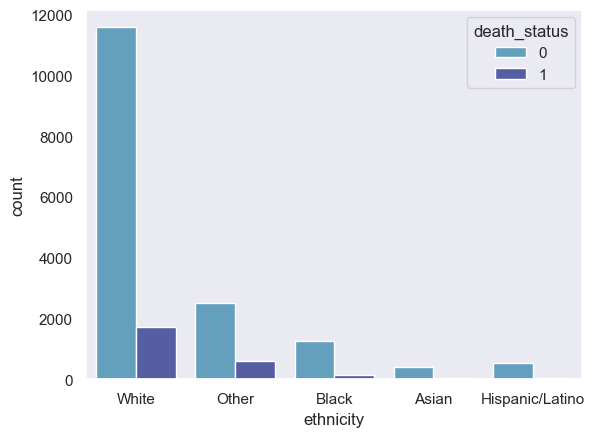

In [15]:
sns.set(style='dark', palette='icefire')
sns.countplot(mimic, x='ethnicity', hue='death_status')

Similar to patients' gender, the pattern of death status is consistent across all ethnicities, indicating no significant association between them.

We then examine at the distribtuuion of patients' age.

#### Age

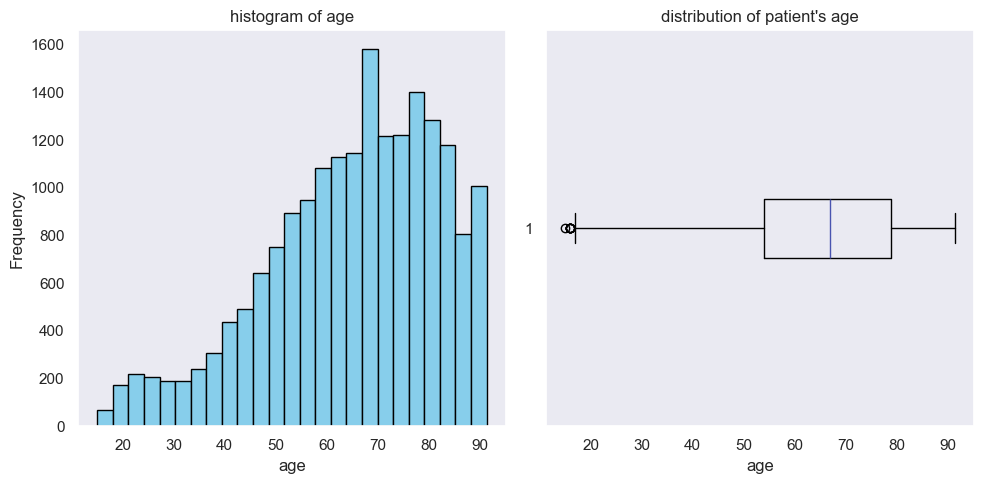

minimum age: 15.0, maximum age: 91.4


In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
axs[0].hist(mimic['age'], bins=25, color='skyblue', edgecolor='black')
axs[0].set_title('histogram of age')
axs[0].set_xlabel('age')
axs[0].set_ylabel('Frequency')

# Box plot
axs[1].boxplot(mimic['age'], vert=False)
axs[1].set_title("distribution of patient's age")
axs[1].set_xlabel("age")

plt.tight_layout()
plt.show()

print(f"minimum age: {min(mimic['age'])}, maximum age: {max(mimic['age'])}")

The patients range in age from a minimum of 15 to a maximum of 91, with the majority being over 50 years old. The age distribution is left-skewed, with some outliers present at the lower end.

### Medical information

Next, we explore the distribution of medical features, which include vital signs and laboratory tests. First, we examine the typical length of ICU stays for patients.

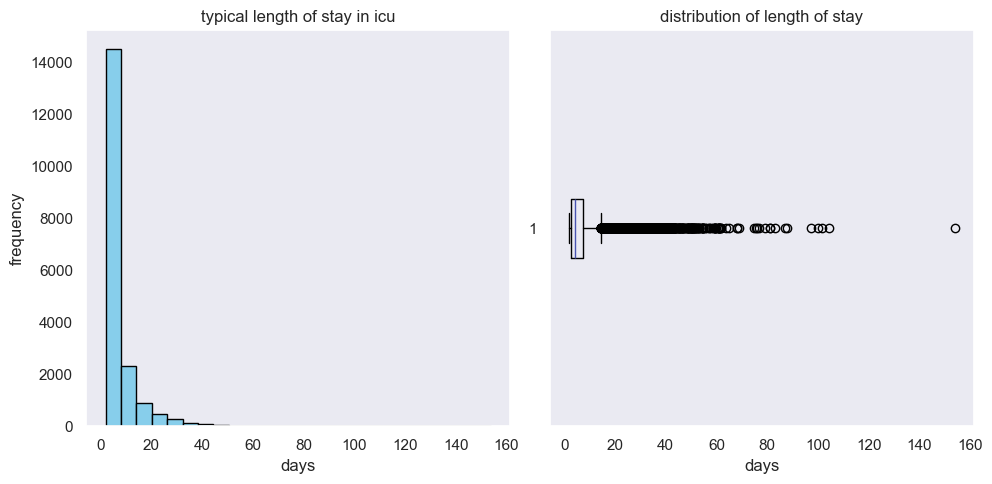

minimum stay: 2.0, maximum stay: 153.928


In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
axs[0].hist(mimic['los'], bins=25, color='skyblue', edgecolor='black')
axs[0].set_title(f'typical length of stay in icu')
axs[0].set_xlabel('days')
axs[0].set_ylabel('frequency')

# Box plot
axs[1].boxplot(mimic['los'], vert=False)
axs[1].set_title(f'distribution of length of stay')
axs[1].set_xlabel("days")

plt.tight_layout()
plt.show()

print(f"minimum stay: {min(mimic['los'])}, maximum stay: {max(mimic['los'])}")

The distribution of ICU stay durations is right-skewed, with many outliers at the upper end. The minimum duration is 2 days, while the maximum is 154 days. Most patients stayed in the ICU for less than 10 days.

We next look at how the LOS differs between patients who died during their ICU stay and those who survived.

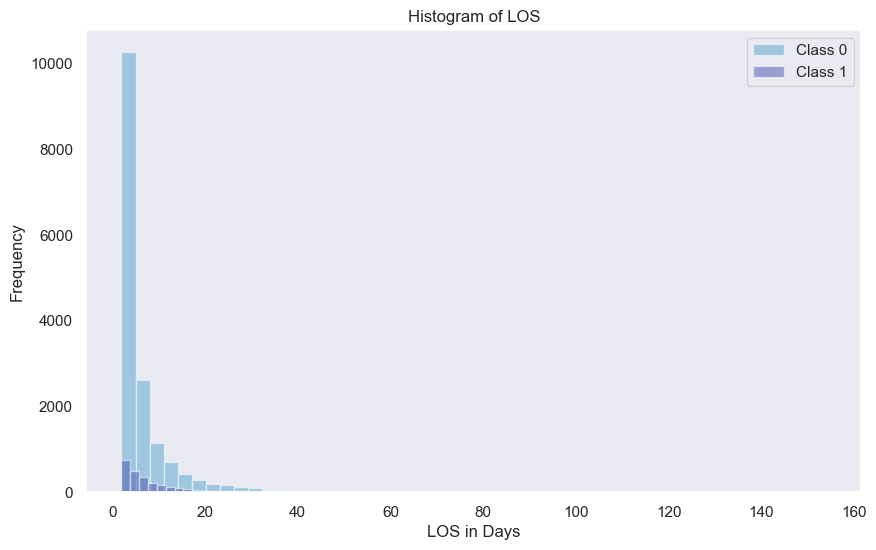

In [18]:
plt.figure(figsize=(10, 6))
    
for cls in mimic['death_status'].unique():
    subset = mimic[mimic['death_status'] == cls]
    plt.hist(subset['los'], alpha=0.5, bins=50, label=f'Class {cls}')

plt.title('Histogram of LOS')
plt.xlabel('LOS in Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The histogram highlights that most patients, regardless of their outcome, tend to have shorter ICU stays, with a small number of patients experiencing longer stays.

Next, we take a closer look at the vital signs and laboratory test features.

#### Vital signs

There are seven vital signs present:

- Temperature (°C)
- Diastolic blood pressure (mmHg)
- Systolic blood pressure (mmHg)
- Mean arterial blood pressure (mmHg)
- Peripheral oxygen saturation (%)
- Heart rate (bpm)
- Respiratory rate (breaths/min)

Before we begin, we first examine at the ranges of the columns.

In [19]:
vital_signs = ['heart_rate', 'dbp', 'sbp', 'map', 'temp', 'spo2', 'resp_rate']

min_max_values = mimic[vital_signs].select_dtypes(include=['number']).agg(['min', 'max'])
min_max_values

heart_rate          dbp      sbp          map        temp           spo2  \
min     36.6875    20.307692     0.00    26.833333    2.507937       8.666667   
max    159.0000  5117.761905  4747.68  3138.363030  143.263889  133403.960000   

      resp_rate  
min    5.888889  
max  161.086957

Based on literature, the valid ranges for the vital signs are as follows:

- Diastolic BP (dbp): 0 to 375 mmHg
- Systolic BP (sbp): 0 to 375 mmHg
- Mean arterial pressure (map): 14 to 330 mmHg
- Temperature (temp): 26 to 45 °C
- Peripheral oxygen saturation (spo2): 0 to 100%
- Heart rate (heart_rate): 0 to 350 bpm
- Respiratory rate (resp_rate): 0 to 300 breaths/min

If our vital signs fall outside these ranges, they will be replaced with NaN.

Examining the ranges of vital signs shows that DBP, SBP, MAP, Temp, and SpO2 exceed the valid ranges, so we replace these values with NaN.

In [20]:
valid_ranges = {'dbp': (0, 375), 'sbp': (0, 375), 'map': (14, 330), 'temp': (26, 45),
                'spo2': (0, 100), 'heart_rate': (0, 350), 'resp_rate': (0, 300)
}

for column, (lower, upper) in valid_ranges.items():
    mimic[column] = mimic[column].apply(lambda x: x if lower <= x <= upper else np.nan)

mimic[vital_signs].select_dtypes(include=['number']).agg(['min', 'max'])

heart_rate         dbp         sbp         map       temp        spo2  \
min     36.6875   20.307692    0.000000   26.833333  26.288889    8.666667   
max    159.0000  309.720000  196.181818  322.000000  44.918056  100.000000   

      resp_rate  
min    5.888889  
max  161.086957

We then examine the distribution of these vital signs.

In [21]:
def plot_histogram_and_boxplot(df, column):
    """
    Plot histogram and box plot for a specified column in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    column (str): Column name to plot.
    xlabel_hist (str): Label for the x-axis of the histogram.
    xlabel_box (str): Label for the x-axis of the box plot.
    title_hist (str): Title for the histogram.
    title_box (str): Title for the box plot.

    Returns:
    None
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Histogram
    axs[0].hist(df[column].dropna(), bins=25, color='skyblue', edgecolor='black')
    axs[0].set_title(f"distribution of {column}")
    axs[0].set_ylabel('Frequency')

    # Box plot
    df.boxplot(column=column, vert=False, grid=False)
    axs[1].set_title(f"boxplot of {column}")

    plt.tight_layout()
    plt.show()

    # print(f'Minimum value of {column}: {df[column].min()}')
    # print(f'Maximum value of {column}: {df[column].max()}')
    # print(f'Number of missing values in {column}: {df[column].isna().sum()}')

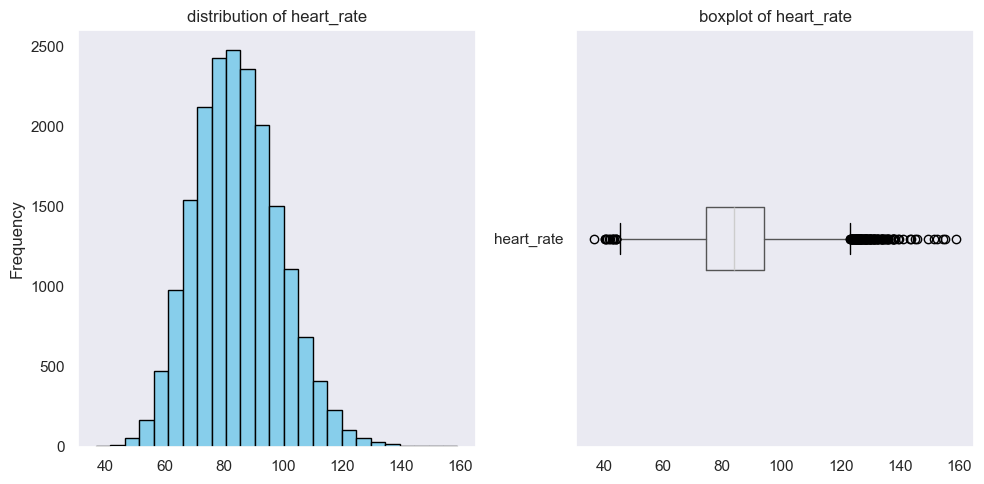

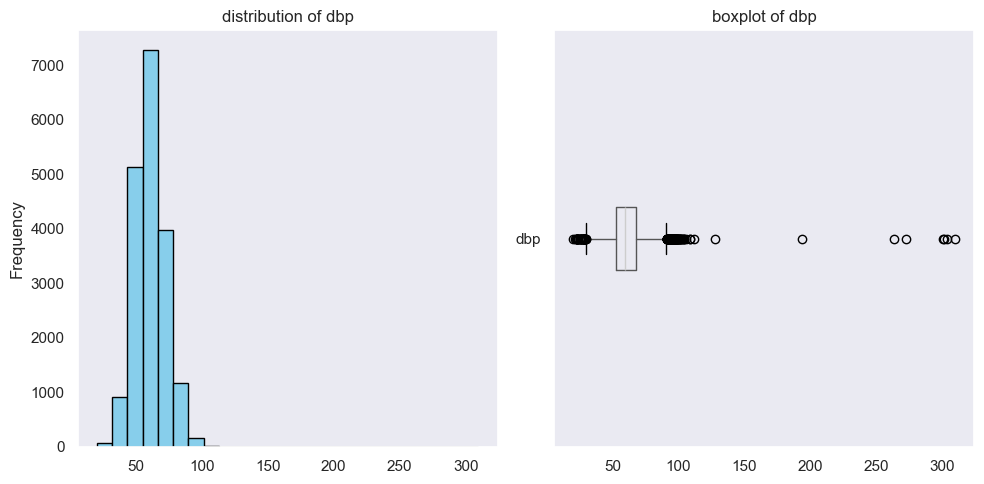

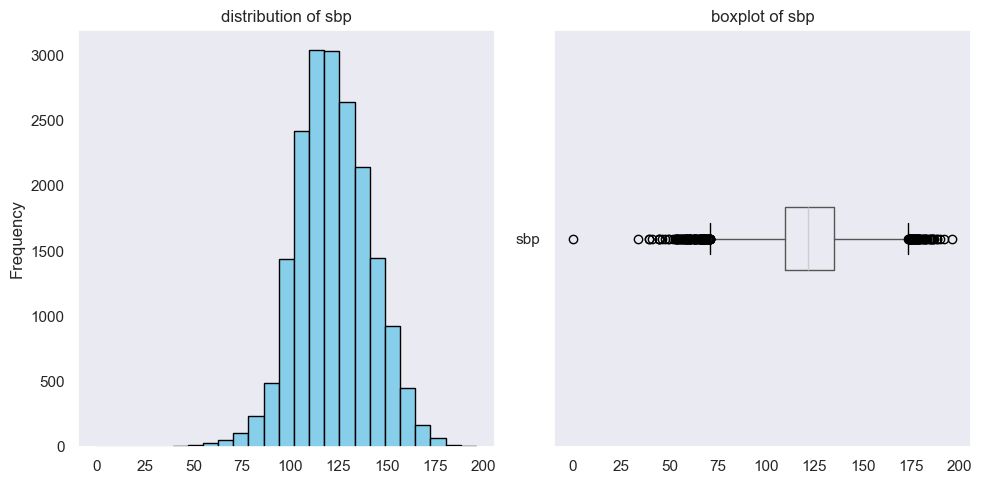

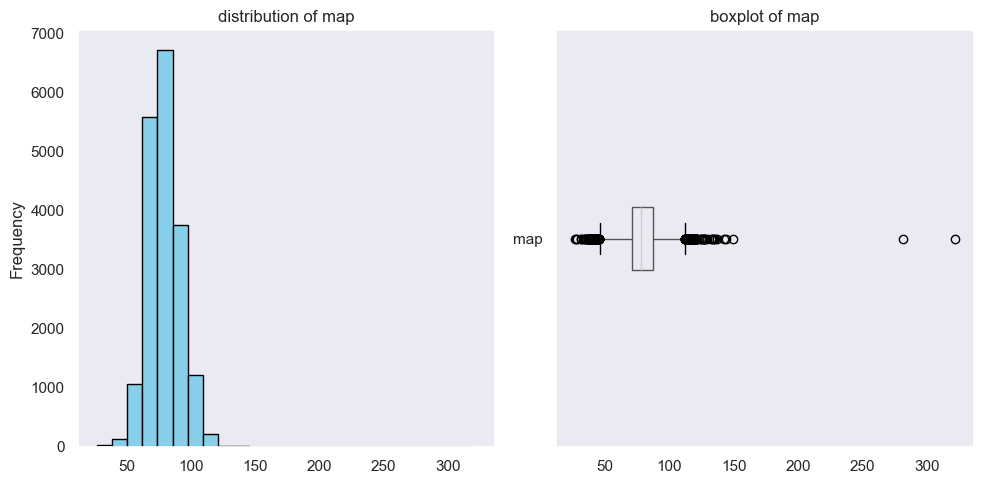

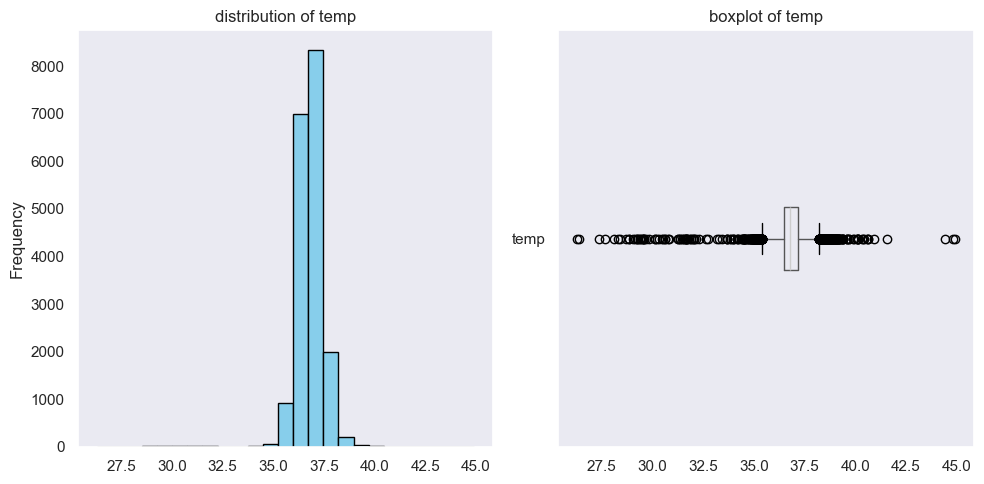

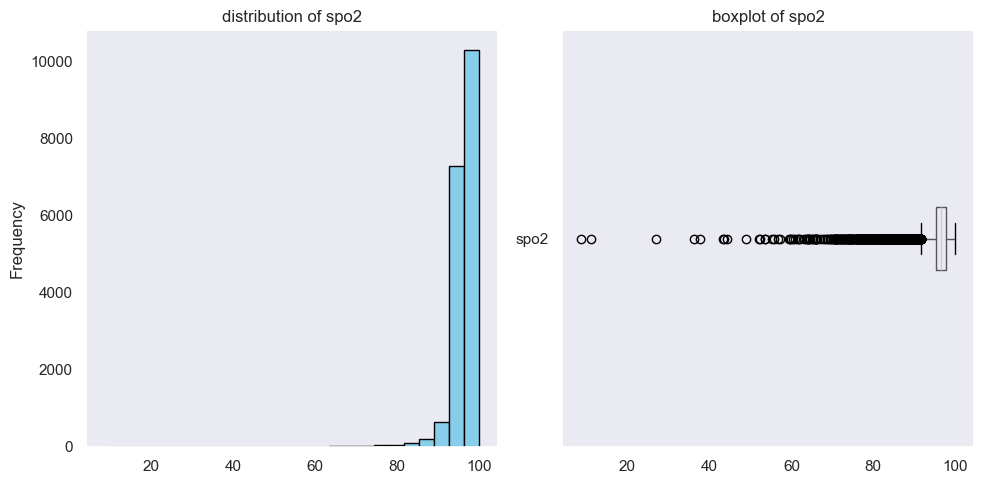

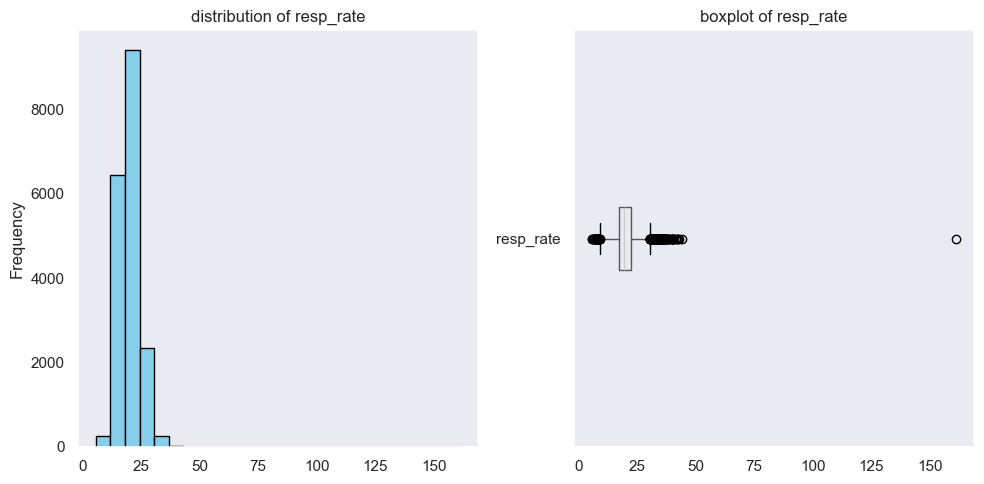

In [22]:
# loop through each vital sign and call the function
for column in vital_signs:
    plot_histogram_and_boxplot(
        df=mimic,
        column=column
    )

Heart rate and SBP appear to have fairly uniform distributions, with outliers present at both the lower and higher ends. The distributions of DBP, MAP, temperature, and respiratory rate are right-skewed, with extreme values on both ends. Temperature is clustered around 37°C, with the majority of values falling within the expected body temperature range. SpO2 is left-skewed, with saturation in the majority of patients and extreme values at the lower end.

#### Laboratory measures

There are 16 laboratory measures present:

- Albumin (g/dL)
- Blood urea nitrogen (mg/dL)
- Bilirubin (mg/dL)
- Lactate (mmol/L)
- Bicarbonate (mEq/L)
- Band neutrophils (%)
- Chloride (mEq/L)
- Creatinine (mg/dL)
- Glucose (mg/dL)
- Hemoglobin (g/dL)
- Hematocrit (g/dL)
- Platelet count (1000/mm^3)
- Potassium (mEq/L)
- Partial thromboplastin time (s)
- Sodium (mEq/L)
- White blood cells (1000/mm^3)

Let's examine the ranges of these laboratory measures.

In [23]:
lab_measures = ["albumin", "bun", "bilirubin", "lactate", "bicarbonate", "neutrophils",
    "chloride", "creatinine", "glucose", "hematocrit", "hemoglobin",
    "platelets", "potassium", "ptt", "sodium", "wbc"]

mimic[lab_measures].select_dtypes(include=['number']).agg(['min', 'max']).T

min          max
albumin        1.000000     5.800000
bun            1.000000   241.000000
bilirubin      0.000000    62.100000
lactate        0.300000    28.100000
bicarbonate    5.000000    51.000000
neutrophils    0.000000    57.000000
chloride      74.250000   140.000000
creatinine     0.000000    15.300000
glucose        8.000000   710.000000
hematocrit     8.700000    55.500000
hemoglobin     2.300000    18.000000
platelets      5.000000  1783.000000
potassium      2.400000     8.500000
ptt           17.500000   150.000000
sodium       101.666667   179.333333
wbc            0.100000   351.100000

The valid ranges for the lab measures are as follows:

- Albumin: 0.6 to 6 g/dL
- Blood urea nitrogen (BUN): 0 to 250 mg/dL
- Bilirubin: 0.1 to 60 mg/dL
- Lactate: 0.4 to 30 mmol/L
- Bicarbonate: 0 to 60 mEq/L
- Band neutrophils: 0 to 100 %
- Chloride: 50 to 175 mEq/L
- Creatinine: 0.1 to 60 mg/dL
- Glucose: 33 to 2000 mg/dL
- Hemoglobin: 0 to 25 g/dL
- Hematocrit: 0 to 75 g/dL
- Platelet count: 0 to 2000 x10^3/mm^3
- Potassium: 0 to 12 mEq/L
- Partial thromboplastin time (PTT): 18.8 to 150 seconds
- Sodium: 50 to 225 mEq/L
- White blood cells (WBC): 0 to 1000 x10^3/mm^3

If our lab measures fall outside these ranges, they will be replaced.

As all the lab measures except bilirubin and PTT fall within the valid range, we take a closer look at bilirubin and PTT.

In [24]:
display(mimic.loc[(mimic['bilirubin'] < 0.1) | (mimic['bilirubin'] > 60), ['bilirubin']])

display(mimic.loc[(mimic['ptt'] < 18.8) | (mimic['ptt'] > 150), ['ptt']])

bilirubin
6199         0.0
12903        0.0
15526       62.1

ptt
805   17.50
7952  18.75
8534  18.70

As there are only a few observations that exceed the valid ranges for bilirubin and PTT, and the values aren’t significantly out of range, we choose to leave them as is.

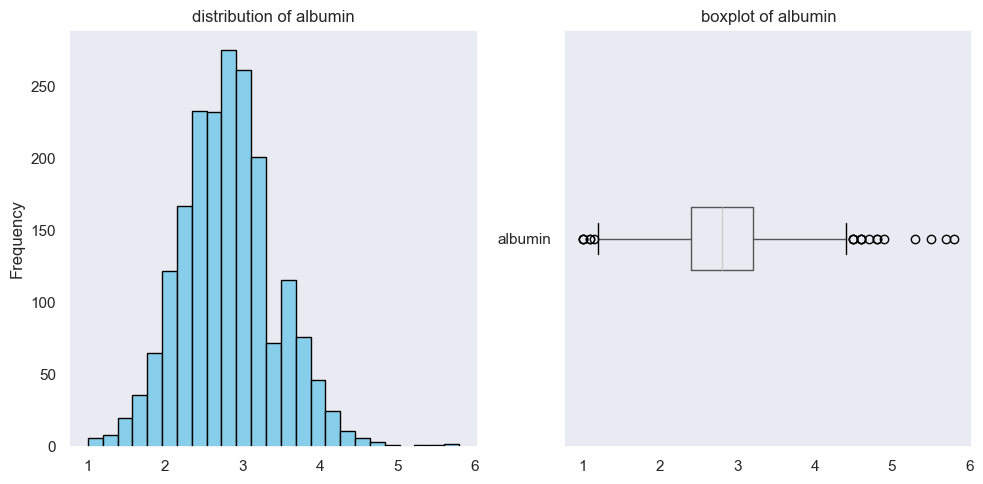

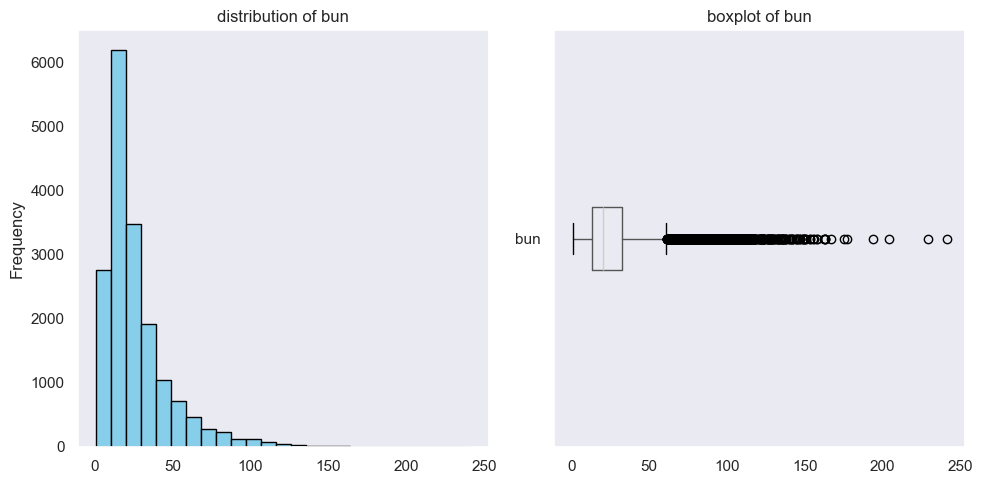

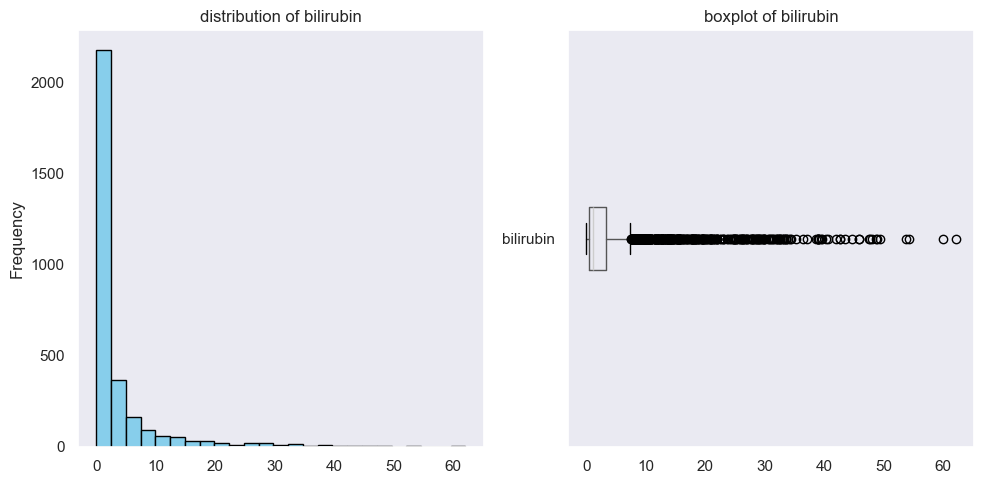

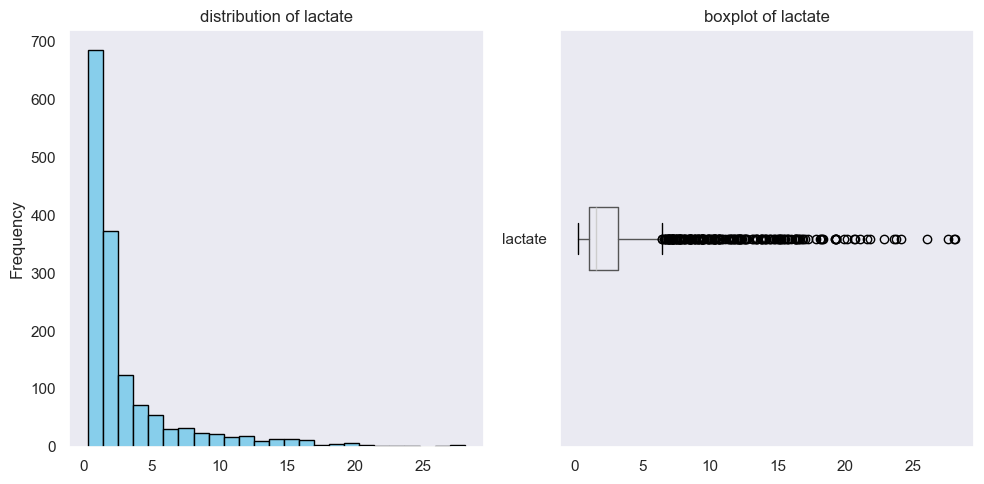

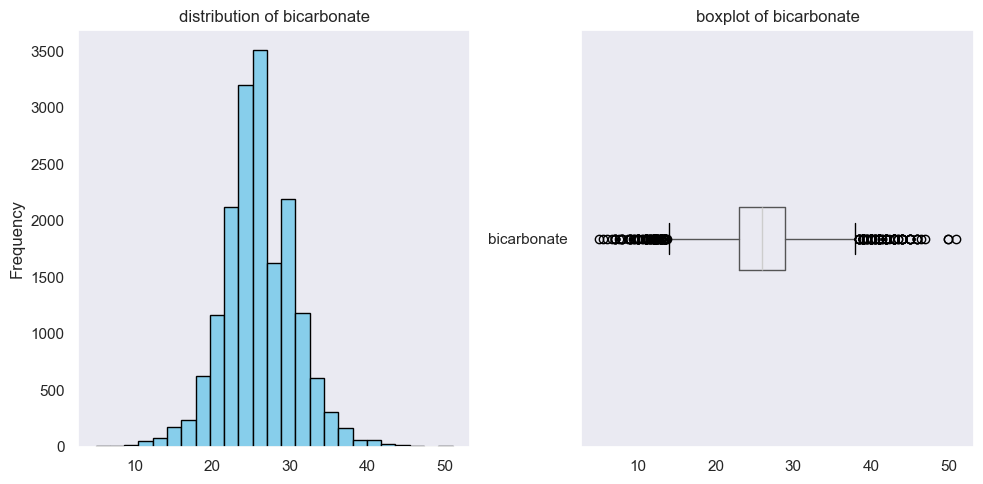

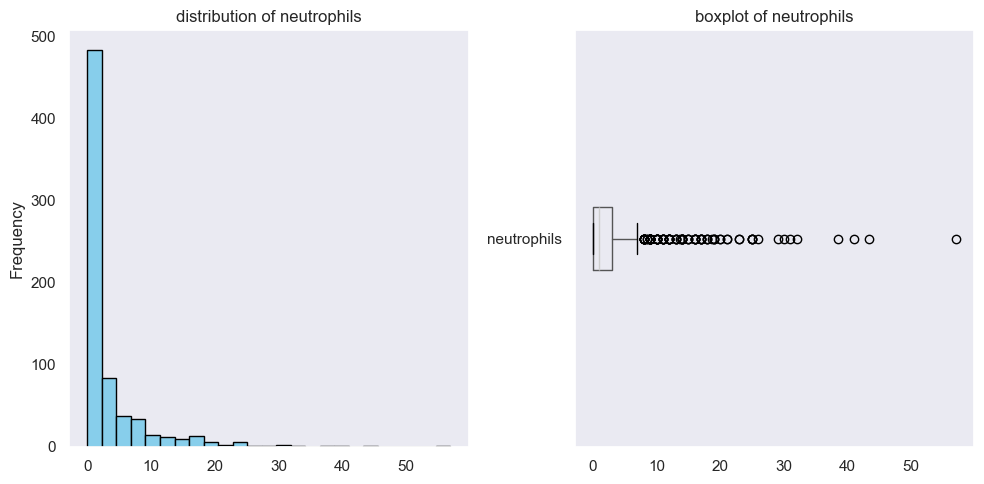

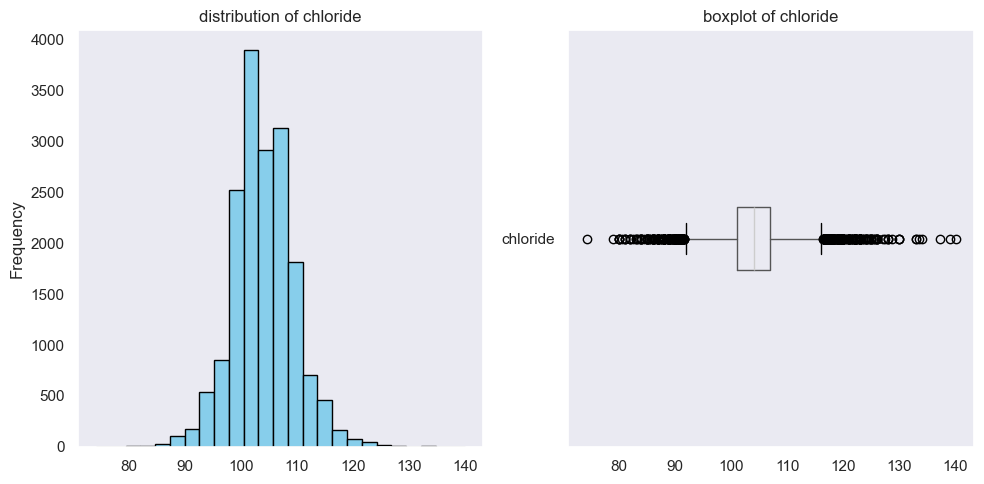

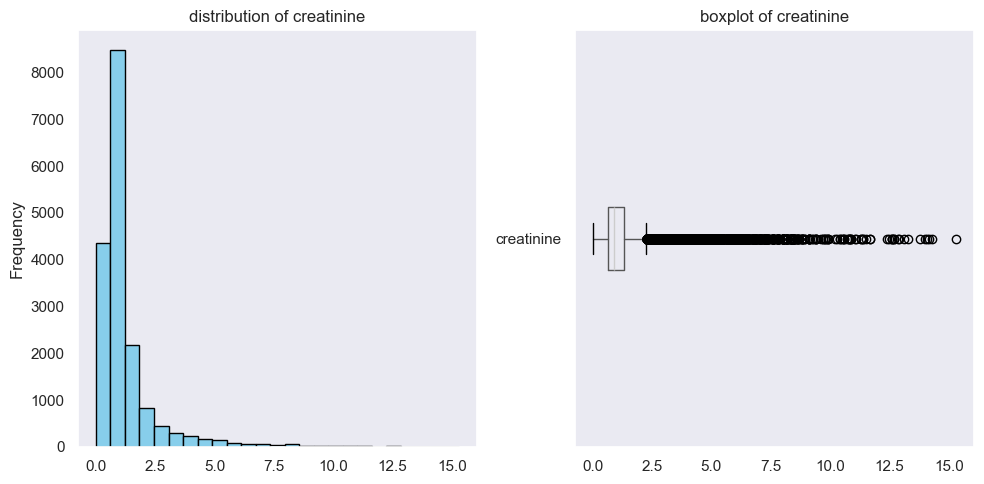

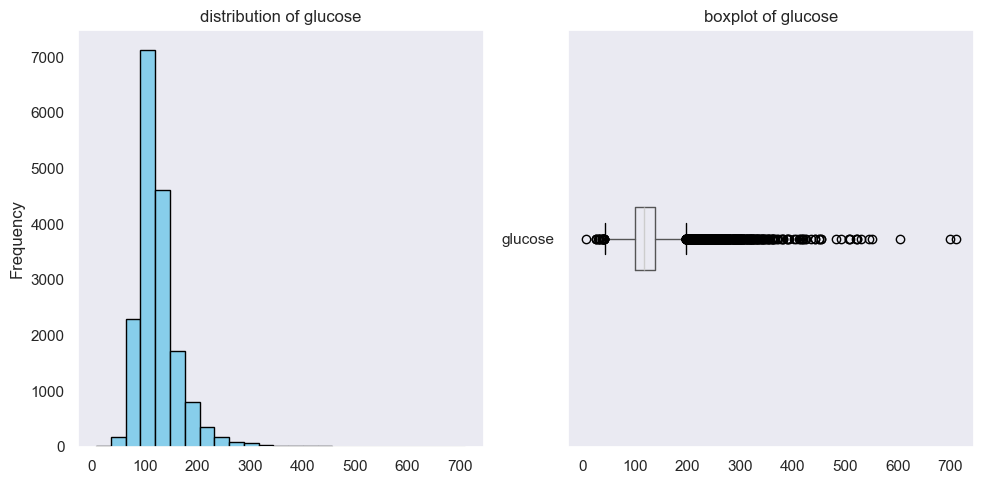

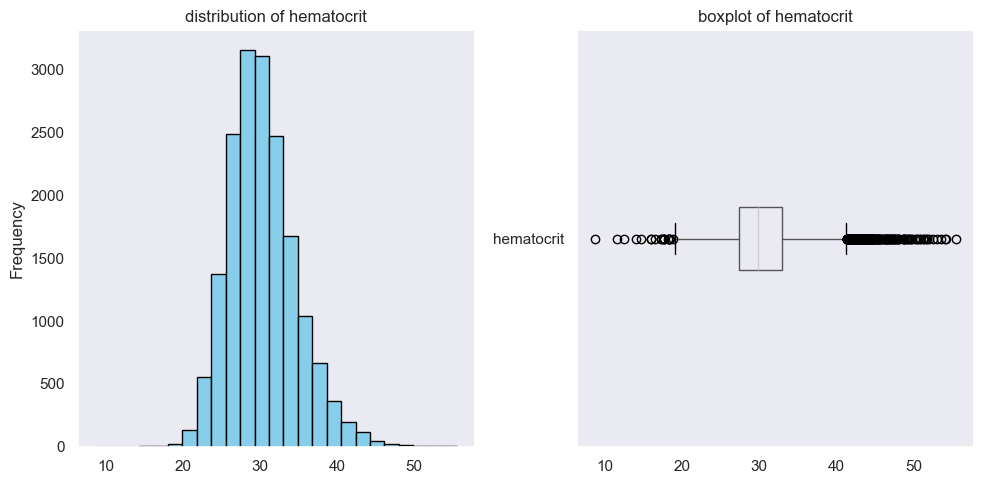

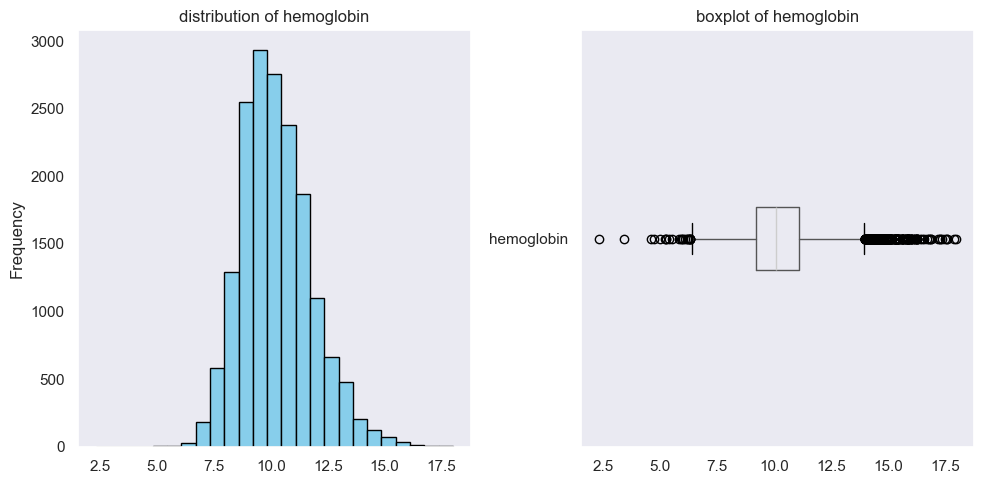

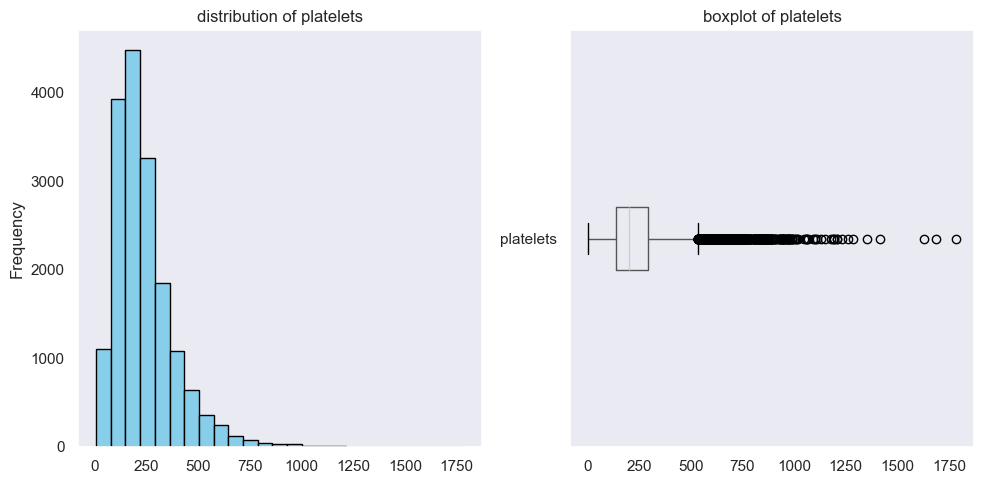

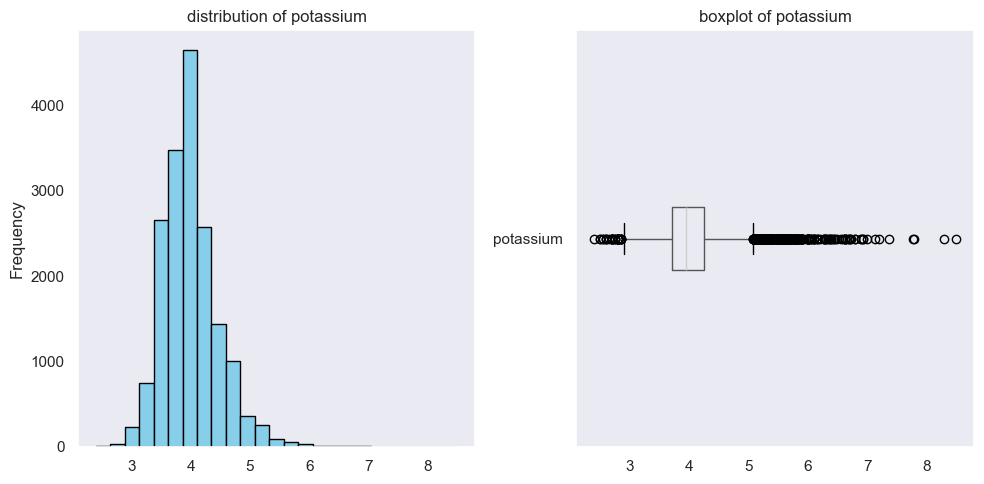

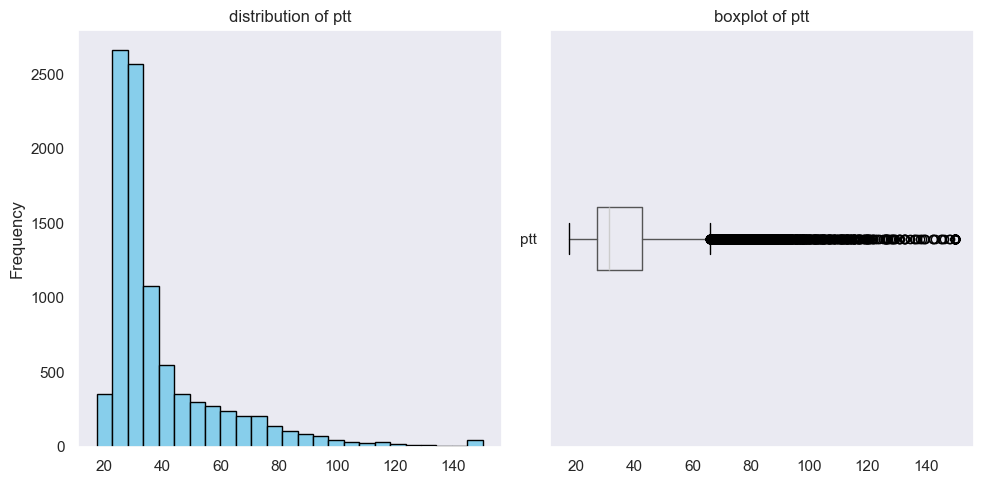

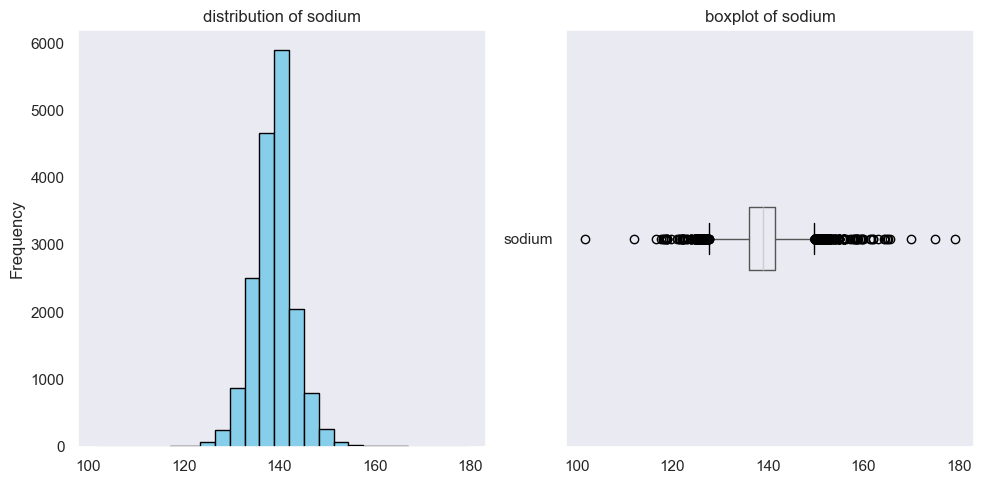

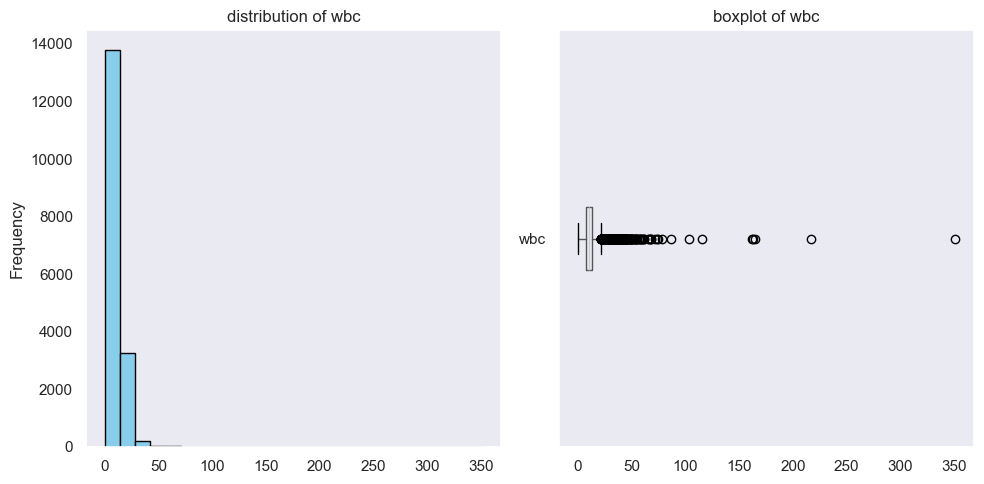

In [25]:
for column in lab_measures:
    plot_histogram_and_boxplot(
        df=mimic,
        column=column)

Albumin, bicarbonate, chloride, and sodium have fairly normal distributions, with extreme values at both the lower and higher ends. The distributions of BUN, bilirubin, lactate, band neutrophils, creatinine, platelet counts, PTT, and WBC are right-skewed, with extreme values at the higher end. Glucose, hematocrit, hemoglobin, and potassium are also right-skewed, but their outliers are present at both the lower and higher ends.

### Missing data

We theorize that if a patient is about to be discharged or near the end of their life, their medical information in the past 24 hours will be collected, which will differ for each target class, as we will either see improvements or deterioration. Therefore, we need to examine the medical information based on different target classes.

But first, we look at the missing values.

In [26]:
# dictionary to store missing data information
missing_data_info = {}

# unique classes in target
classes = mimic['death_status'].unique()

for cls in classes:
    # filter based on the class
    class_df = mimic[mimic['death_status'] == cls]
    
    # calculate the percentage of missing values
    missing_data_info[cls] = class_df.isnull().mean() * 100
missing_data_info['overall'] = mimic.isna().mean() * 100
missing_data_df = pd.DataFrame(missing_data_info).iloc[0:-5]

missing_data_df


0          1    overall
albumin      90.303925  84.083851  89.453001
neutrophils  96.948443  91.692547  96.229421
bicarbonate   3.746770  30.279503   7.376527
bilirubin    84.816045  74.961180  83.467870
bun           3.291497  30.240683   6.978226
chloride      3.556048  29.541925   7.110993
creatinine    3.285345  30.163043   6.962294
dbp           0.326074   1.319876   0.462029
glucose       3.512981  28.843168   6.978226
heart_rate    0.209179   0.271739   0.217738
hematocrit    3.420696  30.357143   7.105682
hemoglobin    4.405070  32.026398   8.183749
lactate      94.899717  72.826087  91.879979
map           0.344531   1.513975   0.504514
ptt          49.864649  50.271739  49.920340
spo2          0.486034   2.445652   0.754116
platelets     4.294328  32.220497   8.114711
potassium     2.713178  28.027950   6.176314
resp_rate     0.486034   0.543478   0.493893
sodium        3.414544  28.998447   6.914498
sbp           0.313769   1.242236   0.440786
temp          0.449120   4.968944   1.067446
wbc           4.275871  32.414596   8.125332

As the columns albumin, band neutrophils, bilirubin, lactate, and PTT have 50% or more missing values regardless of the target class, we have dropped these columns.

In [27]:
mimic = mimic.drop(columns = ['albumin', 'neutrophils', 'bilirubin', 'lactate', 'ptt'])
mimic.head()

bicarbonate   bun  chloride  creatinine        dbp  glucose  heart_rate  \
0         23.0  17.0      96.0         1.3  55.545455     85.0   92.904762   
1         14.0  73.0     101.0         5.1  64.047619    118.0   85.750000   
2         24.0  33.0     107.0         2.0  76.476190    114.0   81.904762   
3         23.0  29.0     100.0         1.1  75.450000    130.0   94.650000   
4         29.0  13.0     104.0         0.4  60.520000    168.5   99.600000   

   hematocrit  hemoglobin        map  ...  resp_rate      sodium         sbp  \
0        29.6         9.7  75.984845  ...  20.363636  131.500000  116.863636   
1        35.7        12.2  93.873014  ...  14.347826  130.000000  153.523810   
2        36.8        12.6  94.850000  ...  16.653846  135.666667  141.666667   
3        36.6        12.4  99.066730  ...  31.400000  135.000000  146.300000   
4        26.9         8.8  78.533332  ...  18.840000  138.000000  125.440000   

        temp   wbc   age  gender  ethnicity     los death_status  
0  35.930556  10.5  76.0       M      White  6.0646            0  
1  36.039682   3.9  66.0       F      White  3.6729            0  
2  35.888889  11.1  41.0       M      Other  5.3231            1  
3  37.074074  30.2  72.0       M      White  7.6348            1  
4  37.687301  14.3  40.0       F      White  3.6660            0  

[5 rows x 23 columns]

#### Vital signs

We then take a closer look at the target classes in the vital signs and their missing values.

<Figure size 1000x600 with 0 Axes>

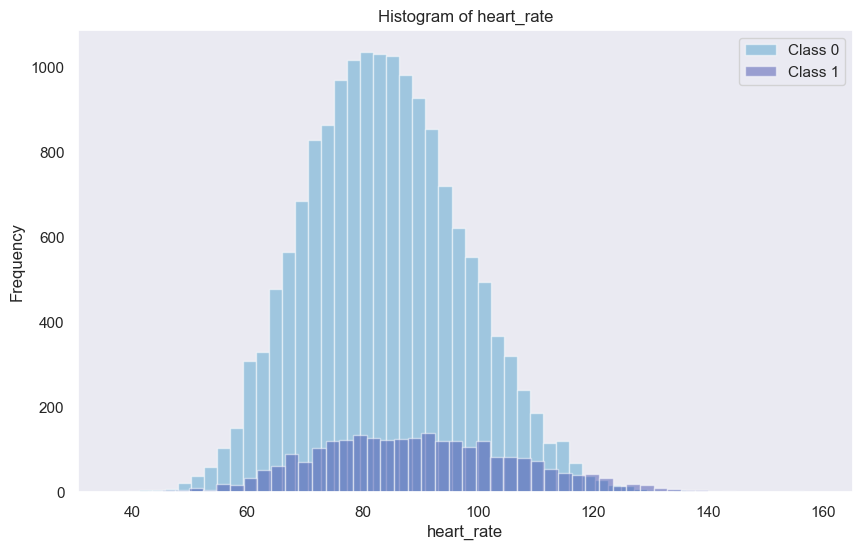

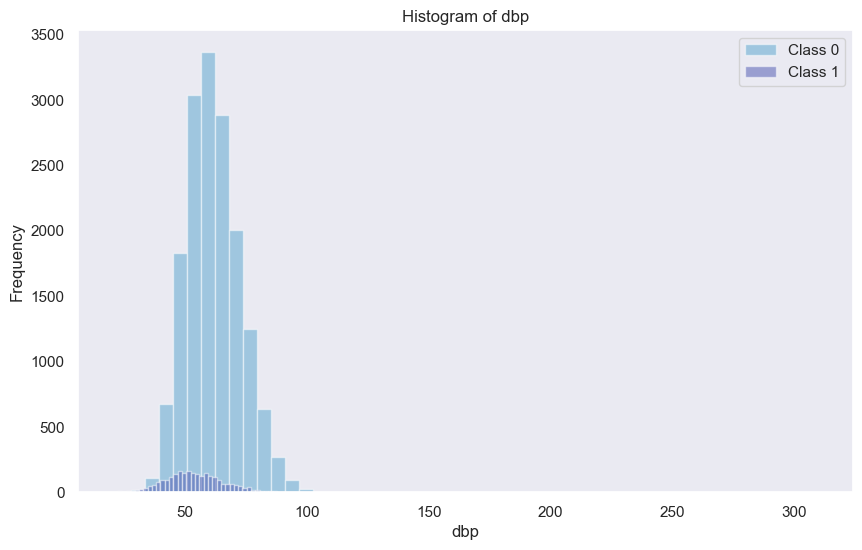

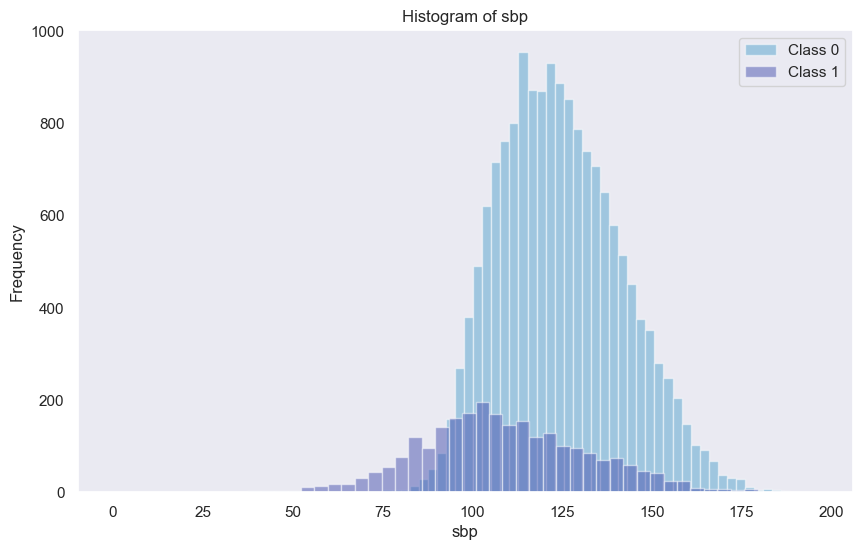

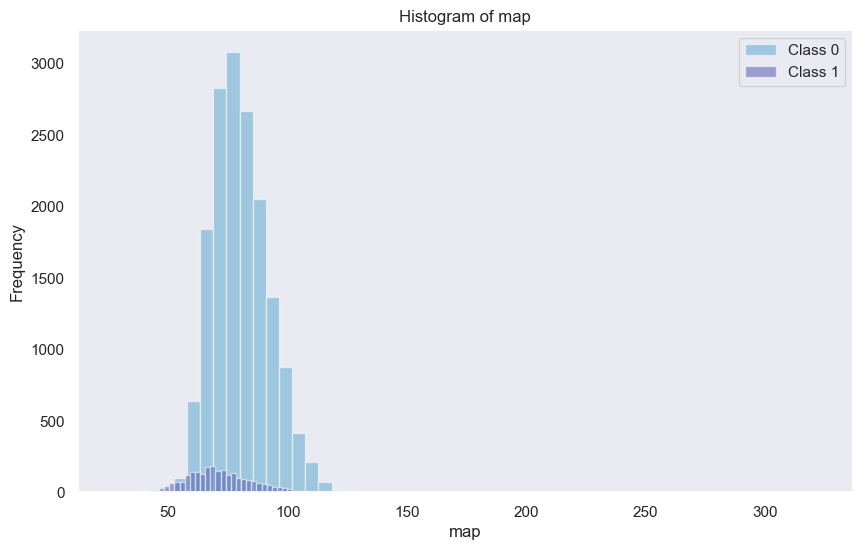

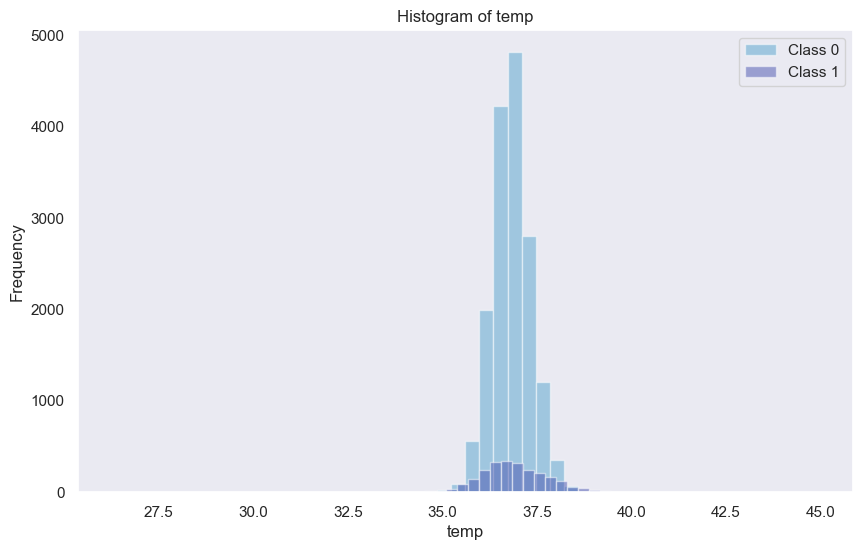

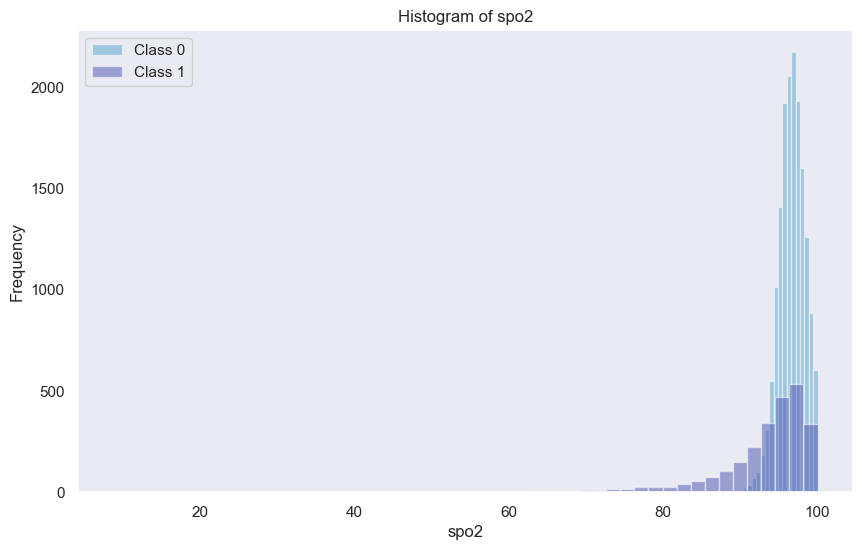

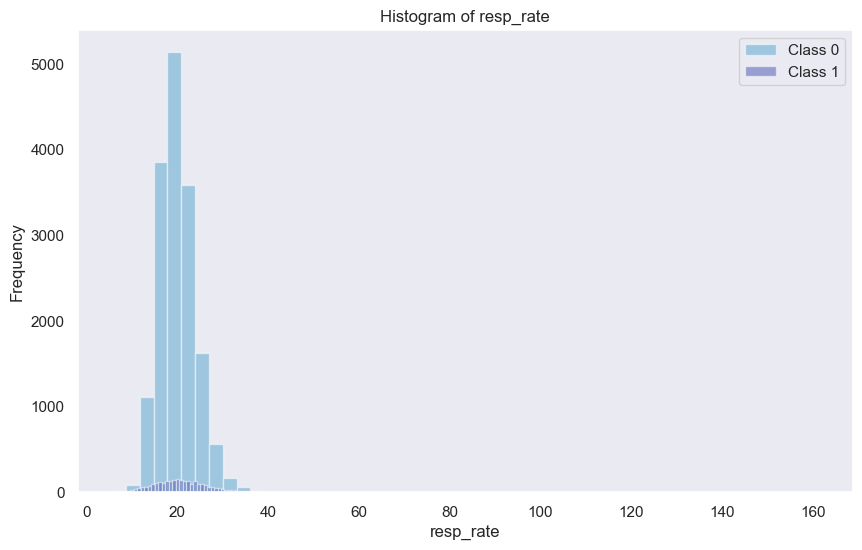

In [28]:
plt.figure(figsize=(10, 6))
    
for column in vital_signs:
    plt.figure(figsize=(10, 6))
    
    for cls in mimic['death_status'].unique():
        subset = mimic[mimic['death_status'] == cls]
        plt.hist(subset[column].dropna(), alpha=0.5, bins=50, label=f'Class {cls}')
    
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Comparison between the two target groups reveals that patients who did not survive the ICU usually have lower DBP, SBP, MAP, and SpO2 levels. Heart rate, temperature, and respiratory rate do not appear to differ significantly between the classes.

Next, we impute missing values based on the different classes using the RandomSampleImputer from the package feature_engine. This method imputes missing data by drawing random samples from the non-missing values in the same column, preserving the original distribution and maintaining natural variability. Since it uses a range of values from the actual data, it is less likely to introduce systematic bias and maintains the original shape and distribution of the data. The distributions before and after imputation are compared using the Kullback-Leibler Divergence (KLD).

In [29]:
from scipy.stats import entropy

# Function to calculate KLD
def calculate_kld(data, target_col, feature_col, epsilon=1e-10):
    class_0_dist = data[data[target_col] == 0][feature_col].value_counts(normalize=True, sort=False)
    class_1_dist = data[data[target_col] == 1][feature_col].value_counts(normalize=True, sort=False)
    all_values = pd.concat([class_0_dist, class_1_dist], axis=1).fillna(0)
    all_values += epsilon
    all_values.iloc[:, 0] /= all_values.iloc[:, 0].sum()
    all_values.iloc[:, 1] /= all_values.iloc[:, 1].sum()
    kld_value = entropy(all_values.iloc[:, 0], all_values.iloc[:, 1])
    return kld_value

# Calculate KLD before imputation
kld_before_imputation = {col: calculate_kld(mimic, 'death_status', col) for col in vital_signs}

# Impute missing values using median based on classes
data_imputed_median = mimic.copy()
for cls in mimic['death_status'].unique():
    class_data = mimic[mimic['death_status'] == cls]
    for col in vital_signs:
        median_value = class_data[col].median()
        data_imputed_median.loc[mimic['death_status'] == cls, col] = class_data[col].fillna(median_value)

# Calculate KLD after median imputation based on classes
kld_after_median_class_imputation = {col: calculate_kld(data_imputed_median, 'death_status', col) for col in vital_signs}

# Identify columns with missing values within the vital signs
columns_with_missing = [col for col in vital_signs if mimic[col].isnull().any()]

# Impute missing values using RandomSampleImputer based on classes
data_imputed_random_class = mimic.copy()
for cls in mimic['death_status'].unique():
    class_data = mimic[mimic['death_status'] == cls]
    imputer = RandomSampleImputer(variables=columns_with_missing, random_state=0)
    imputer.fit(class_data)
    imputed_class_data = imputer.transform(class_data)
    data_imputed_random_class.loc[mimic['death_status'] == cls] = imputed_class_data

# Calculate KLD after RandomSampleImputer based on classes
kld_after_random_class_imputation = {col: calculate_kld(data_imputed_random_class, 'death_status', col) for col in vital_signs}

# Create a DataFrame to compare KLD values
kld_df = pd.DataFrame({
    'KLD': kld_before_imputation,
    'KLD median imputation': kld_after_median_class_imputation,
    'KLD random sample imputation': kld_after_random_class_imputation
})

# Display the KLD DataFrame
display(kld_df)

KLD  KLD median imputation  KLD random sample imputation
heart_rate  10.742659              10.753079                     10.745013
dbp         10.567222              10.589705                     10.571367
sbp         11.638915              11.654600                     11.639817
map         12.061363              12.078452                     12.059145
temp        10.229210              10.203194                     10.238040
spo2         5.321413               5.316279                      5.321810
resp_rate    7.820026               7.792015                      7.830462

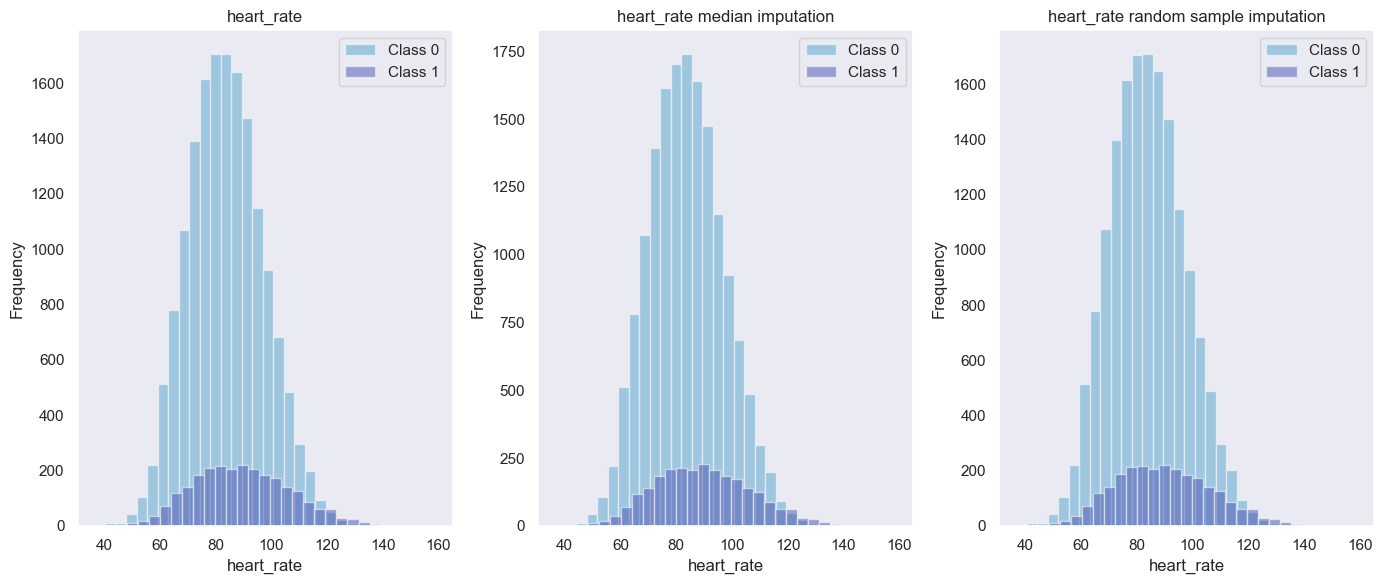

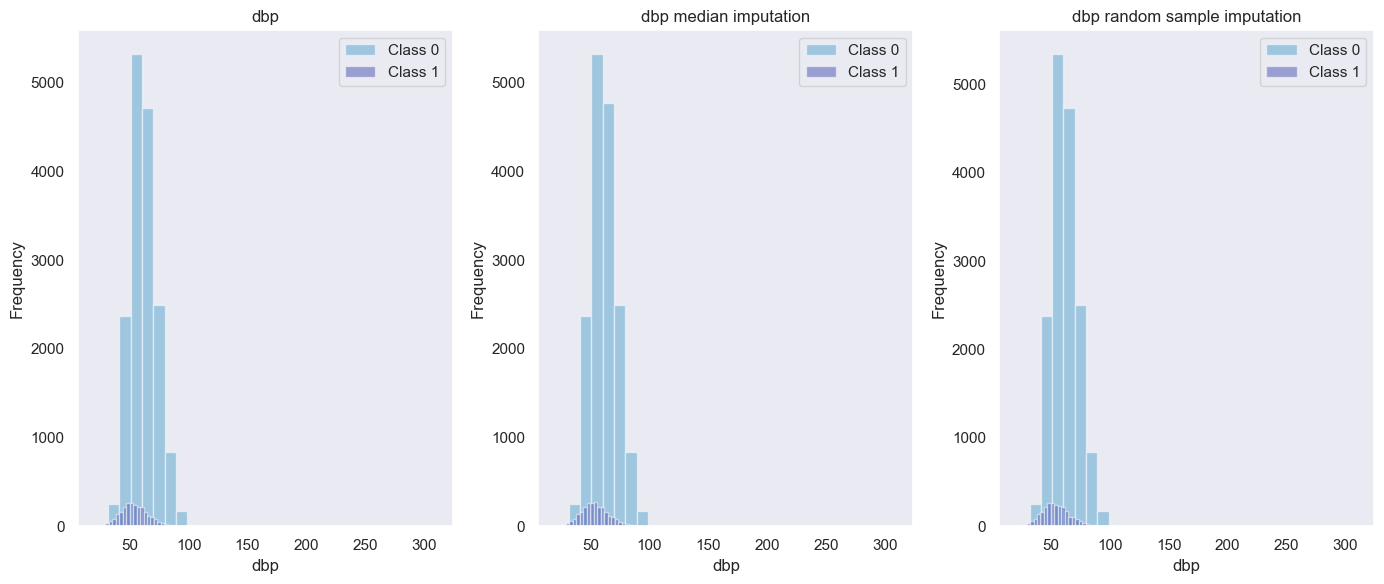

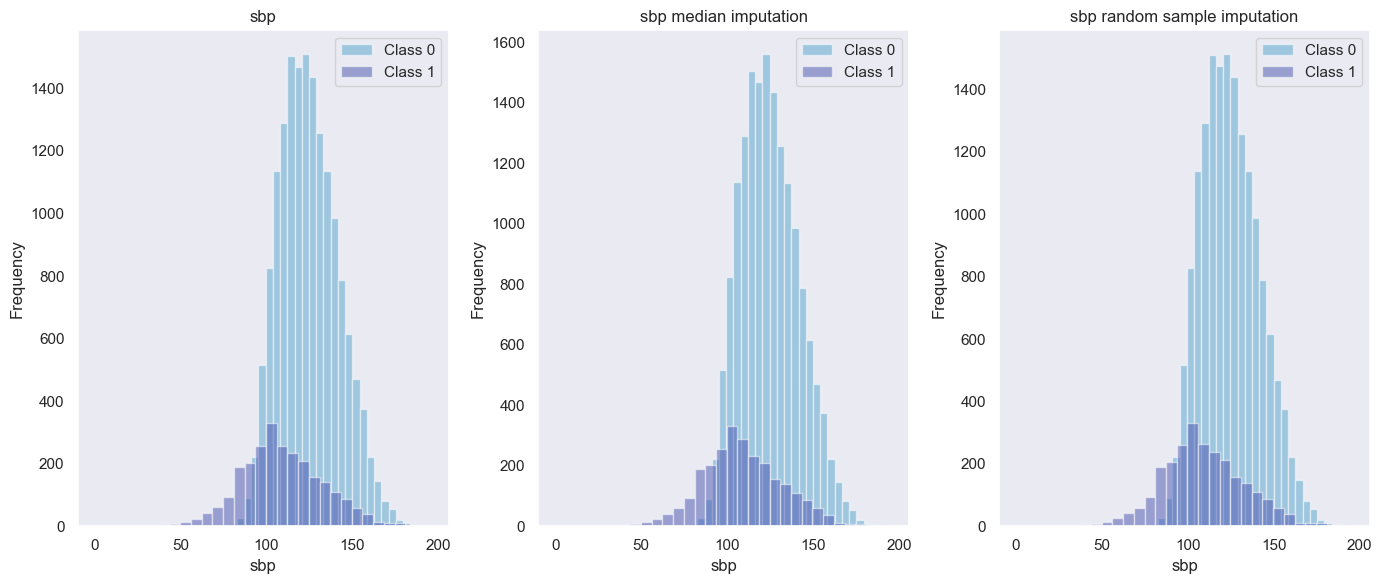

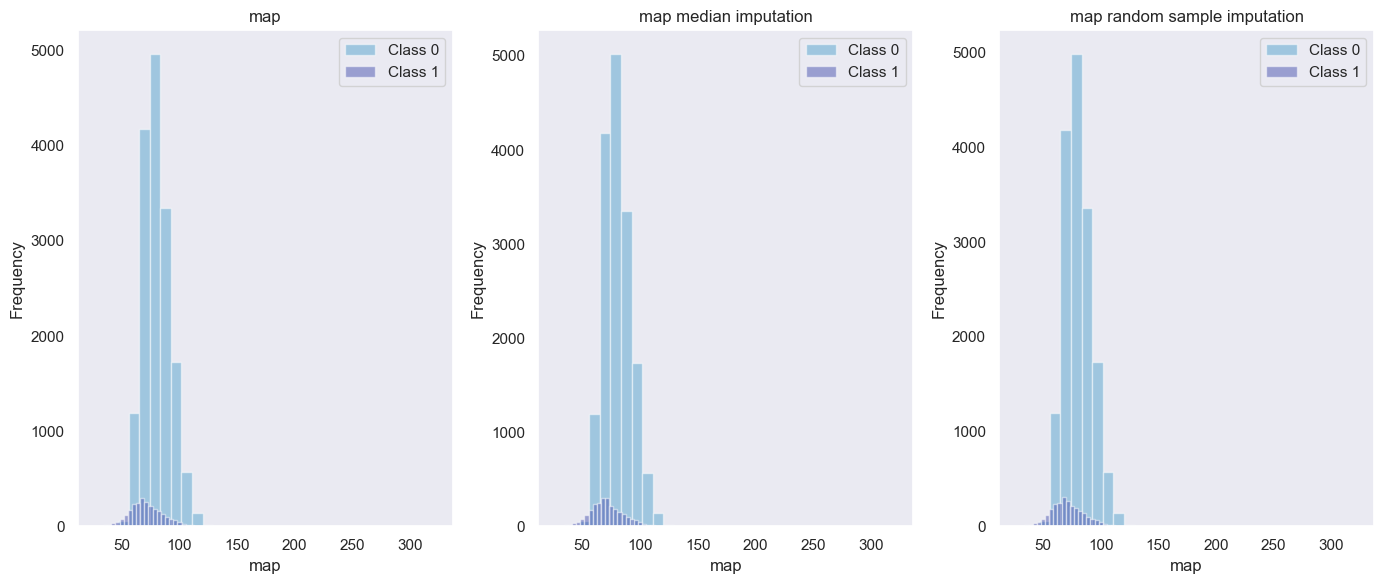

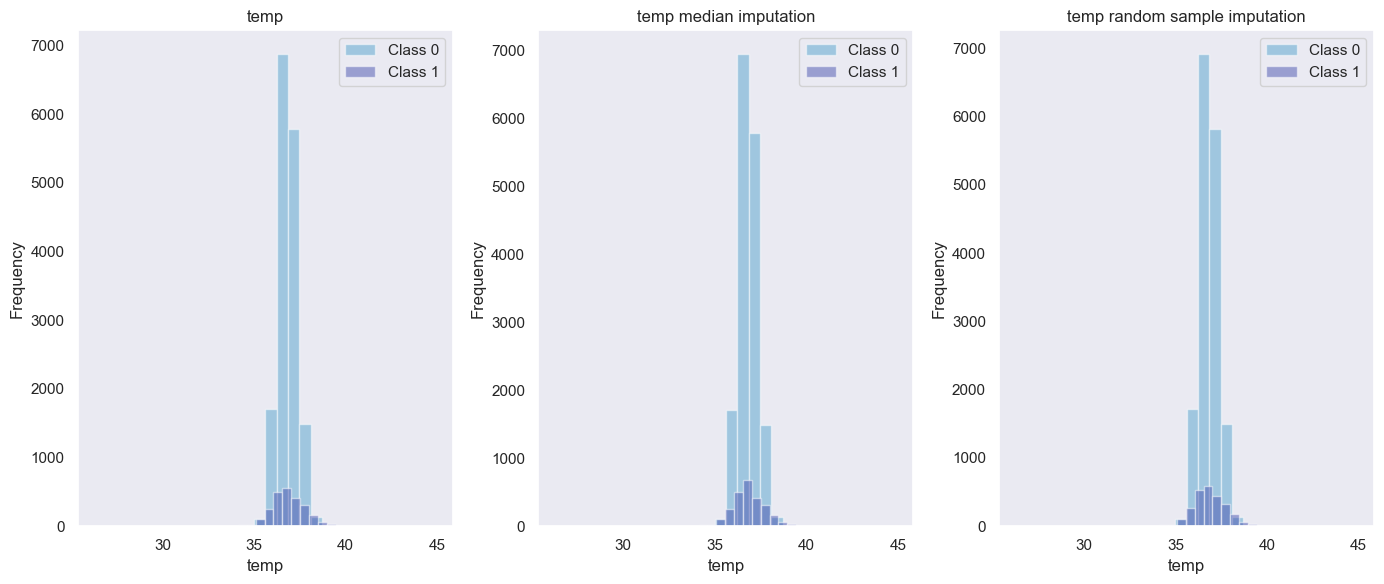

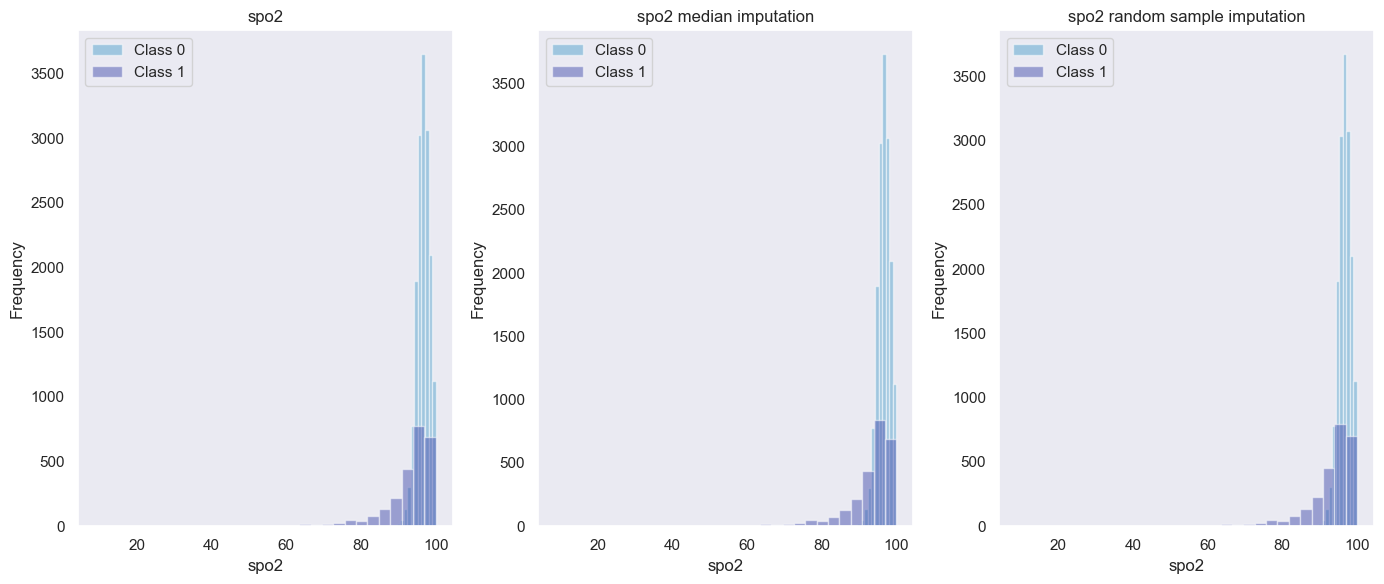

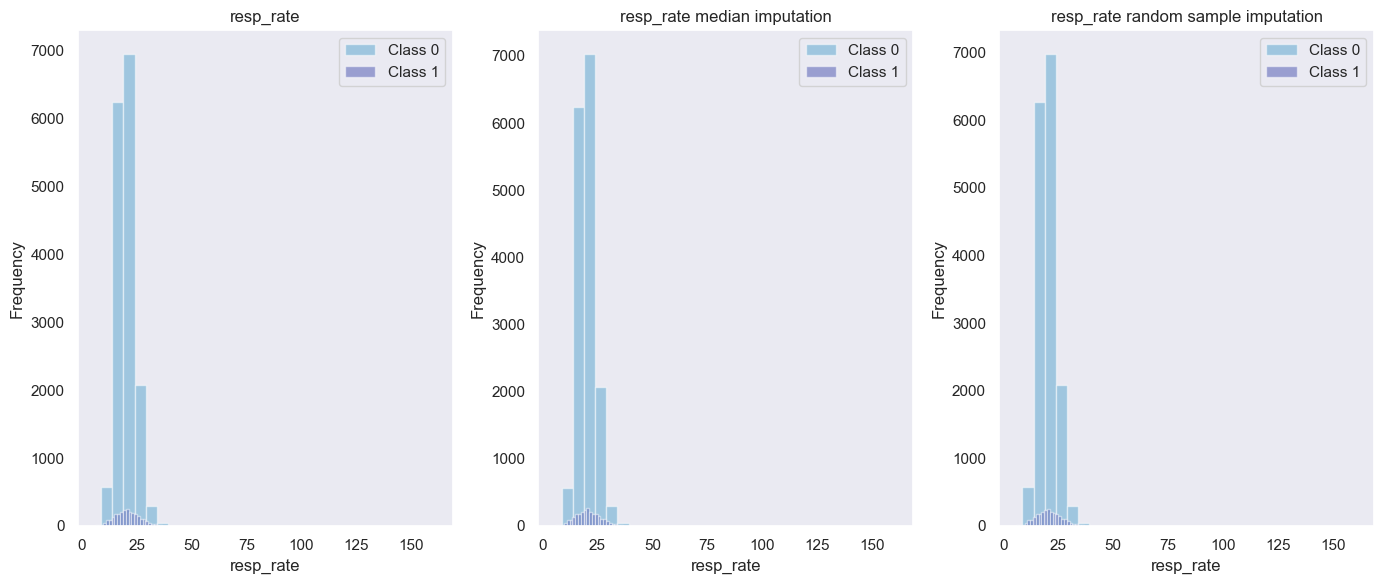

In [30]:
# Plot histograms for each vital sign column before and after imputation
for col in vital_signs:
    plt.figure(figsize=(14, 6))
    
    # Before imputation
    plt.subplot(1, 3, 1)
    for cls in mimic['death_status'].unique():
        subset = mimic[mimic['death_status'] == cls]
        plt.hist(subset[col].dropna(), alpha=0.5, bins=30, label=f'Class {cls}')
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    
    # After median class-based imputation
    plt.subplot(1, 3, 2)
    for cls in data_imputed_median['death_status'].unique():
        subset = data_imputed_median[data_imputed_median['death_status'] == cls]
        plt.hist(subset[col].dropna(), alpha=0.5, bins=30, label=f'Class {cls}')
    plt.title(f'{col} median imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    
    # After random class-based imputation
    plt.subplot(1, 3, 3)
    for cls in data_imputed_random_class['death_status'].unique():
        subset = data_imputed_random_class[data_imputed_random_class['death_status'] == cls]
        plt.hist(subset[col].dropna(), alpha=0.5, bins=30, label=f'Class {cls}')
    plt.title(f'{col} random sample imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

The KLD values before and after imputation are similar for both the median and random sample imputations. As the random sample imputation is closer to the before-imputation KLD value, we will use the random sample imputation to handle missing values.

In [31]:
# Initialize the RandomSampleImputer for vital signs
imputer = RandomSampleImputer(variables=vital_signs, random_state=0)

# Fit the imputer on the data
imputer.fit(mimic)

# Transform the data
mimic_vital_no_null = imputer.transform(mimic)

# Display the transformed data to verify missing values have been imputed
mimic_vital_no_null[vital_signs].isnull().sum()

heart_rate    0
dbp           0
sbp           0
map           0
temp          0
spo2          0
resp_rate     0
dtype: int64

#### Lab measures
We next examine the distribution of lab measures for different target classes and their missing values.

<Figure size 1000x600 with 0 Axes>

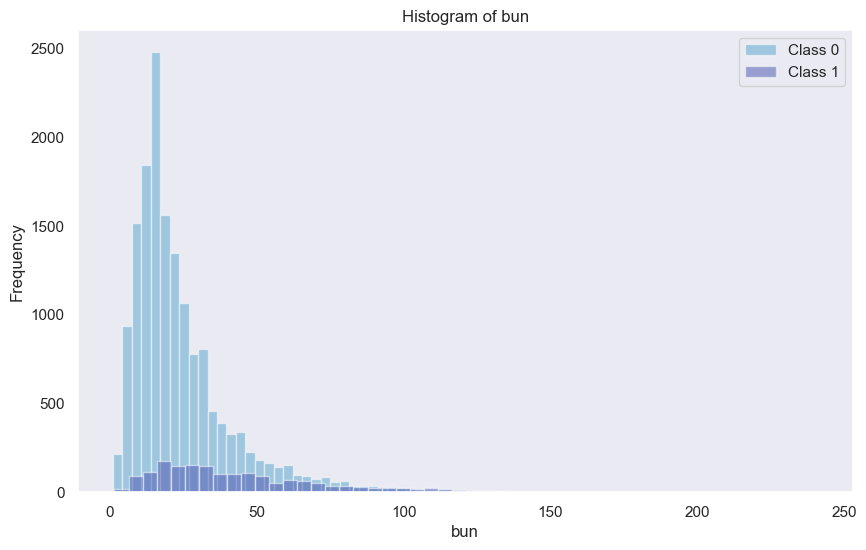

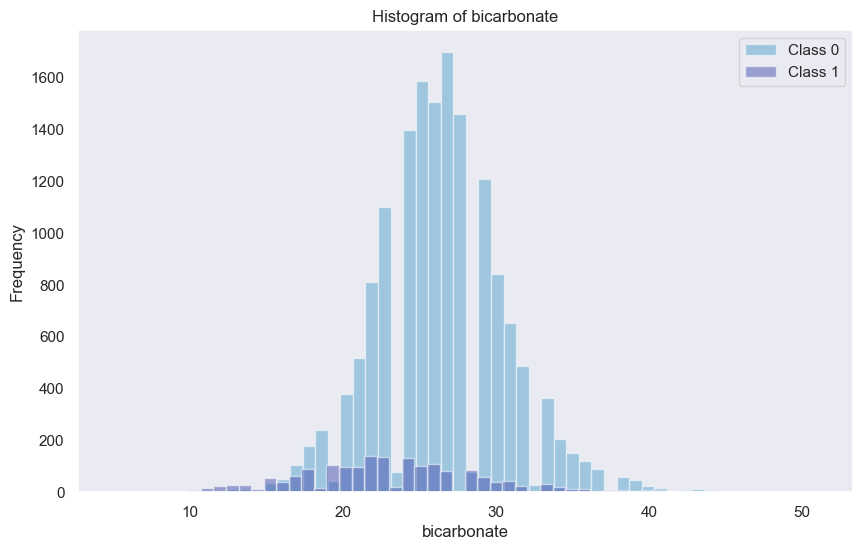

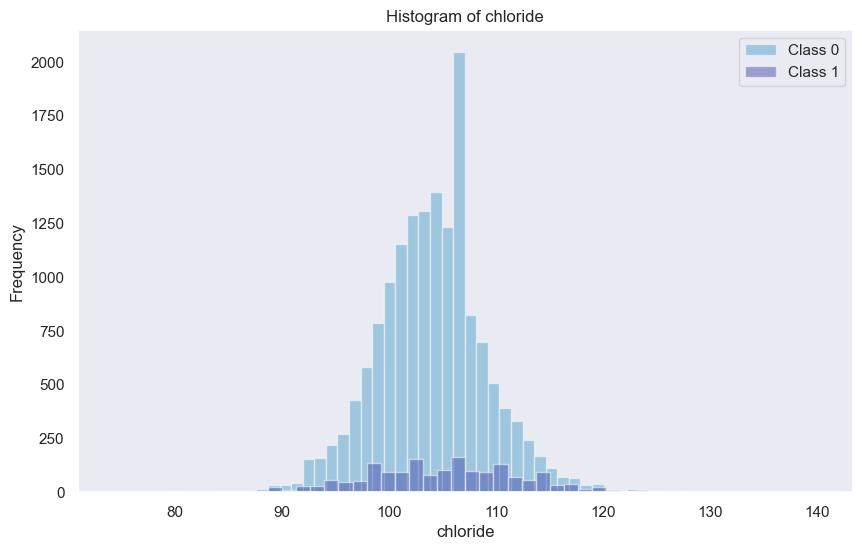

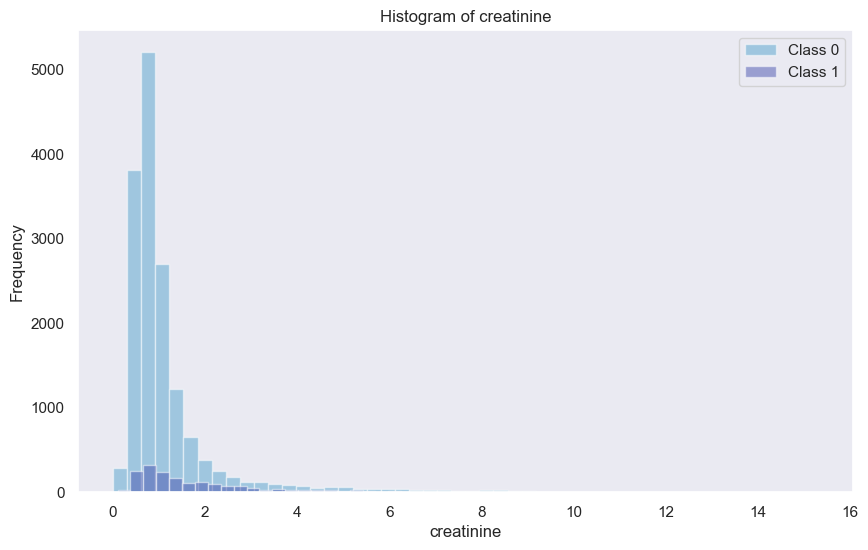

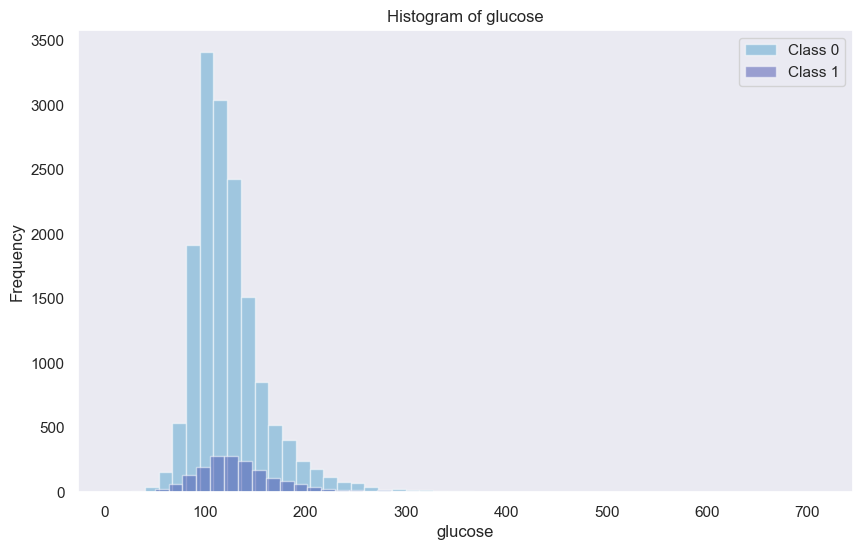

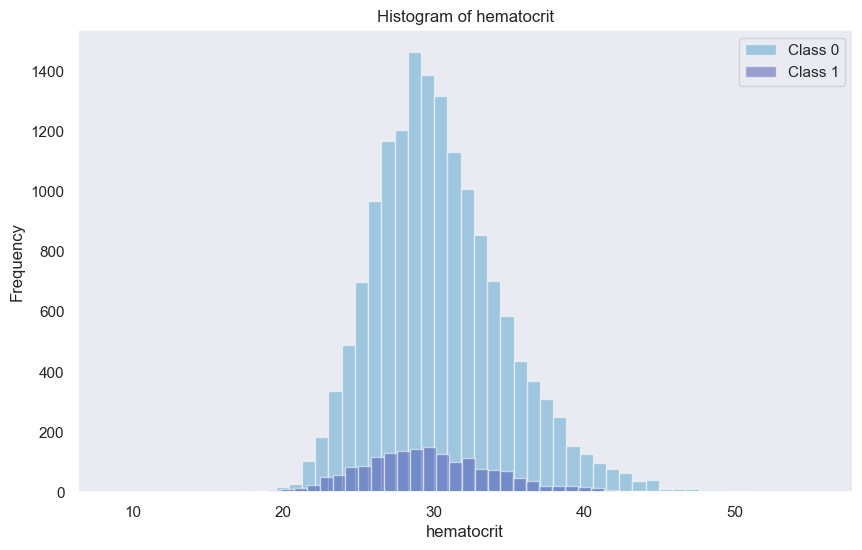

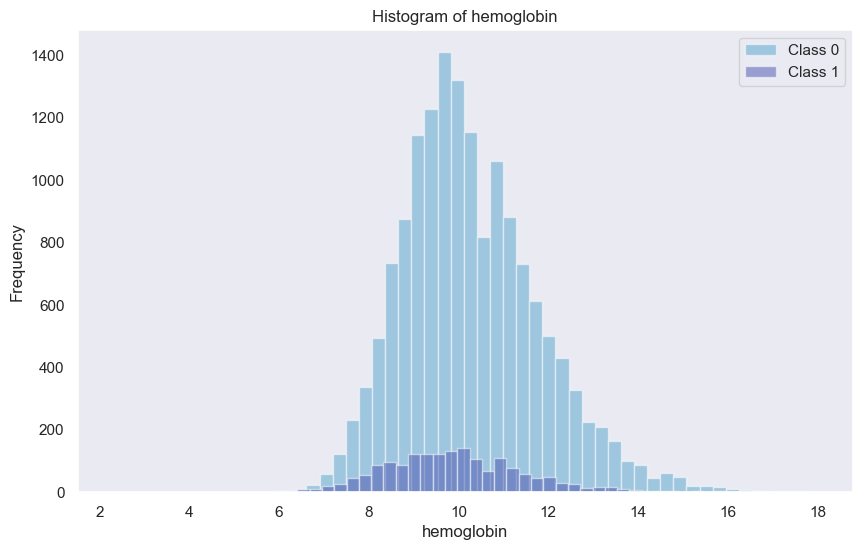

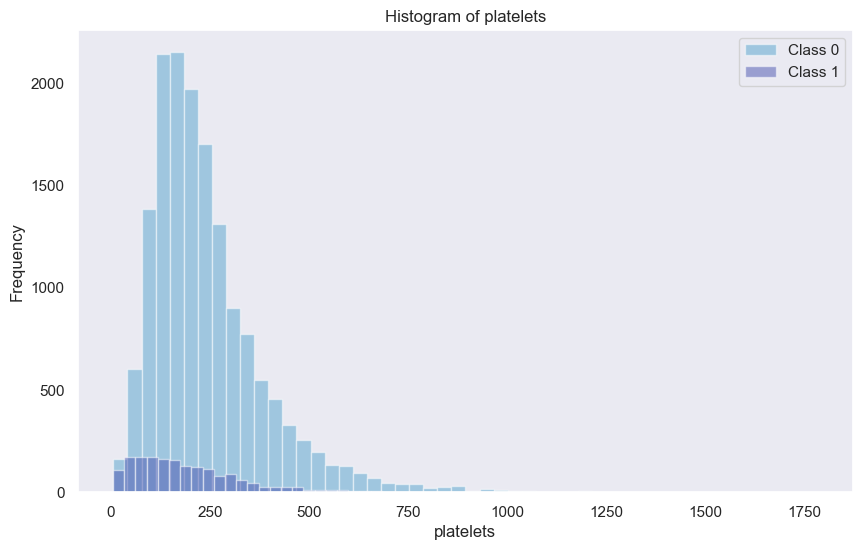

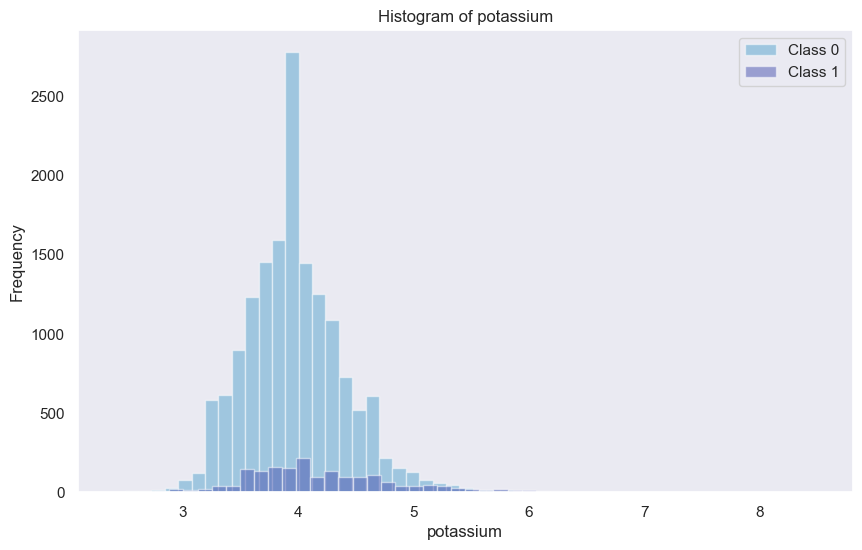

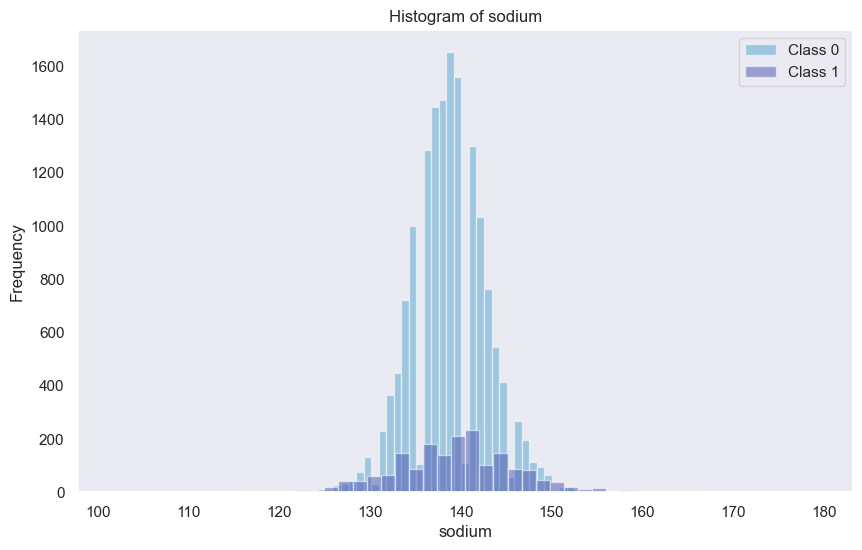

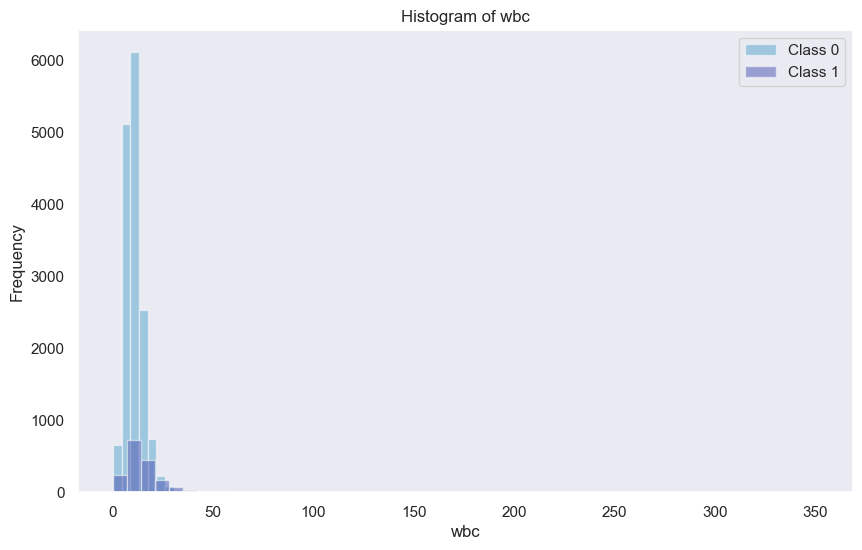

In [32]:
plt.figure(figsize=(10, 6))

lab_measures2 = ["bun", "bicarbonate", "chloride", "creatinine", "glucose",
                 "hematocrit", "hemoglobin", "platelets", "potassium", "sodium", "wbc"]

for column in lab_measures2:
    plt.figure(figsize=(10, 6))
    
    for cls in mimic['death_status'].unique():
        subset = mimic[mimic['death_status'] == cls]
        plt.hist(subset[column].dropna(), alpha=0.5, bins=50, label=f'Class {cls}')
    
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Laboratory measures between patients who survived and those who did not show that BUN, chloride, creatinine, glucose, potassium, sodium, and WBC have similar distributions. However, for patients who did not survive, the measures are lower for bicarbonate, hematocrit, hemoglobin, and platelet counts.

In [33]:
# Calculate KLD before imputation
kld_before_imputation = {col: calculate_kld(mimic, 'death_status', col) for col in lab_measures2}

# Impute missing values using median based on classes
data_imputed_median = mimic.copy()
for cls in mimic['death_status'].unique():
    class_data = mimic[mimic['death_status'] == cls]
    for col in lab_measures2:
        median_value = class_data[col].median()
        data_imputed_median.loc[mimic['death_status'] == cls, col] = class_data[col].fillna(median_value)

# Calculate KLD after median imputation based on classes
kld_after_median_class_imputation = {col: calculate_kld(data_imputed_median, 'death_status', col) for col in lab_measures2}

# Identify columns with missing values within the vital signs
columns_with_missing = [col for col in lab_measures2 if mimic[col].isnull().any()]

# Impute missing values using RandomSampleImputer based on classes
data_imputed_random_class = mimic.copy()
for cls in mimic['death_status'].unique():
    class_data = mimic[mimic['death_status'] == cls]
    imputer = RandomSampleImputer(variables=columns_with_missing, random_state=0)
    imputer.fit(class_data)
    imputed_class_data = imputer.transform(class_data)
    data_imputed_random_class.loc[mimic['death_status'] == cls] = imputed_class_data

# Calculate KLD after RandomSampleImputer based on classes
kld_after_random_class_imputation = {col: calculate_kld(data_imputed_random_class, 'death_status', col) for col in lab_measures2}

# Create a DataFrame to compare KLD values
kld_df = pd.DataFrame({
    'KLD': kld_before_imputation,
    'KLD median imputation': kld_after_median_class_imputation,
    'KLD random sample imputation': kld_after_random_class_imputation
})

# Display the KLD DataFrame
display(kld_df)

KLD  KLD median imputation  KLD random sample imputation
bun          0.767340               1.095184                      0.796221
bicarbonate  0.446083               0.684212                      0.446800
chloride     0.320234               0.529884                      0.328228
creatinine   0.554858               0.926907                      0.552837
glucose      1.161490               1.448877                      1.182857
hematocrit   1.766217               2.072636                      1.792049
hemoglobin   0.592917               0.882179                      0.594489
platelets    2.226841               2.546832                      2.255409
potassium    0.547745               0.738254                      0.558707
sodium       0.319038               0.648282                      0.330599
wbc          1.162038               1.554917                      1.206786

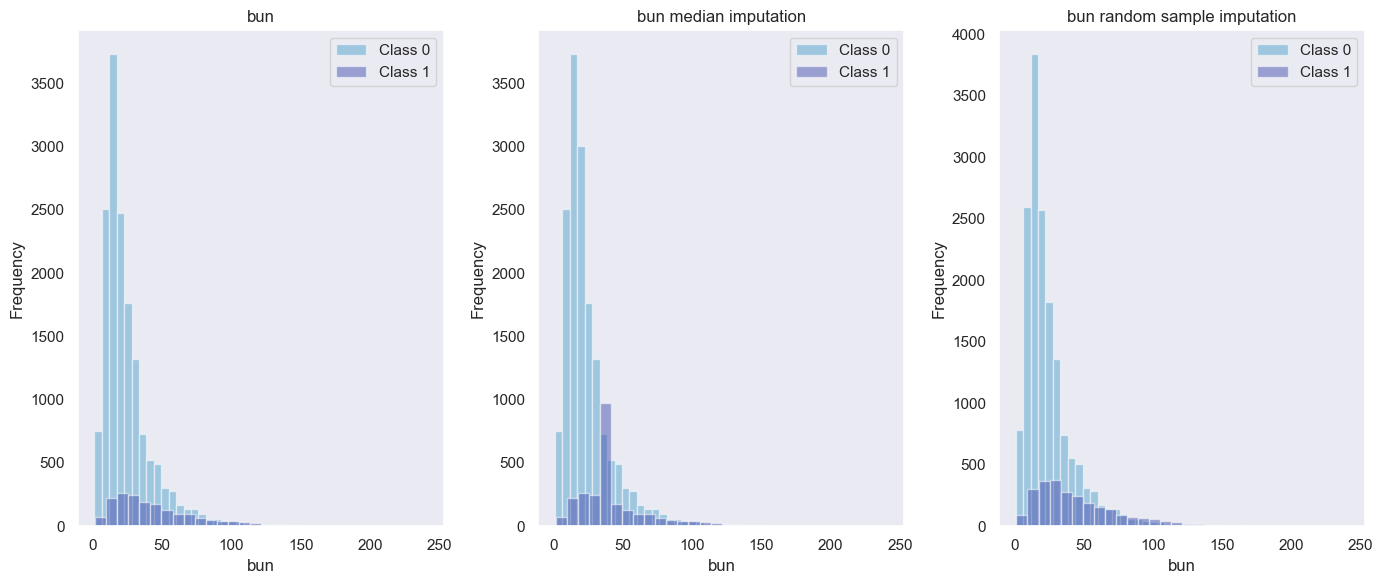

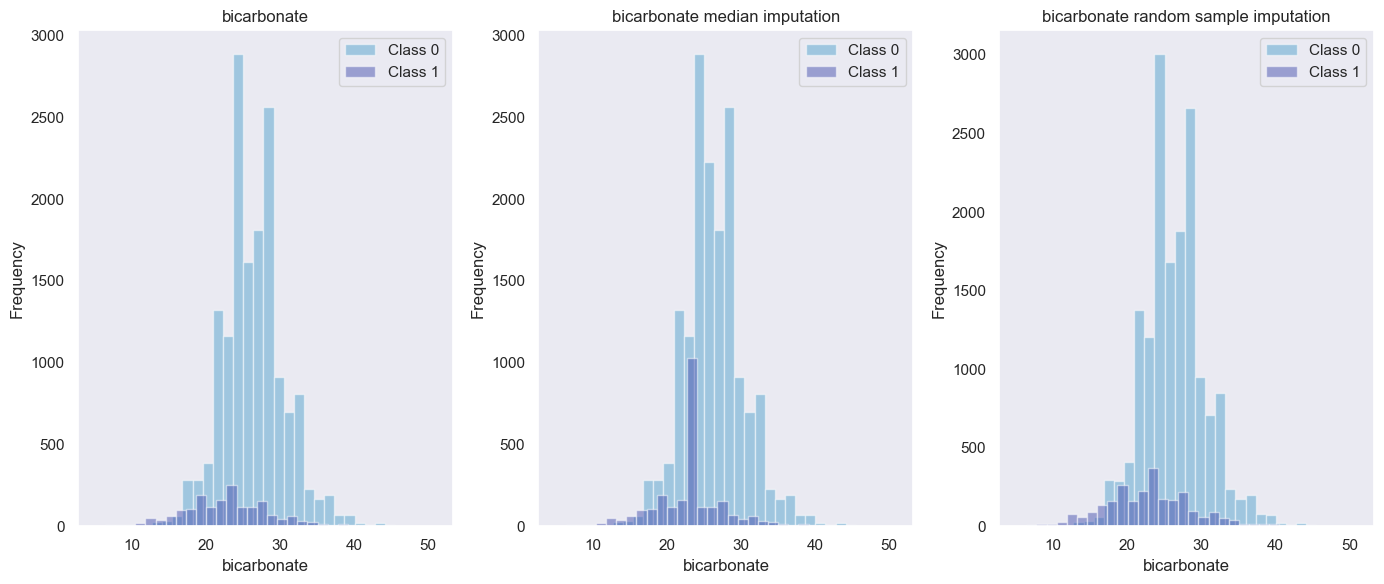

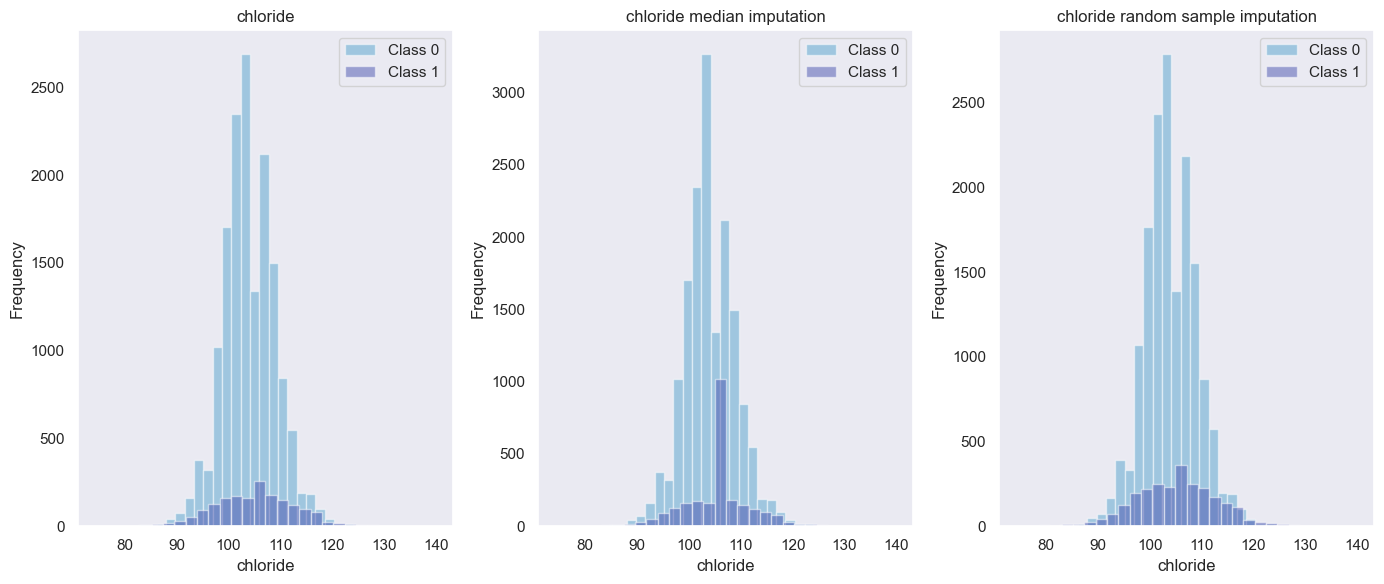

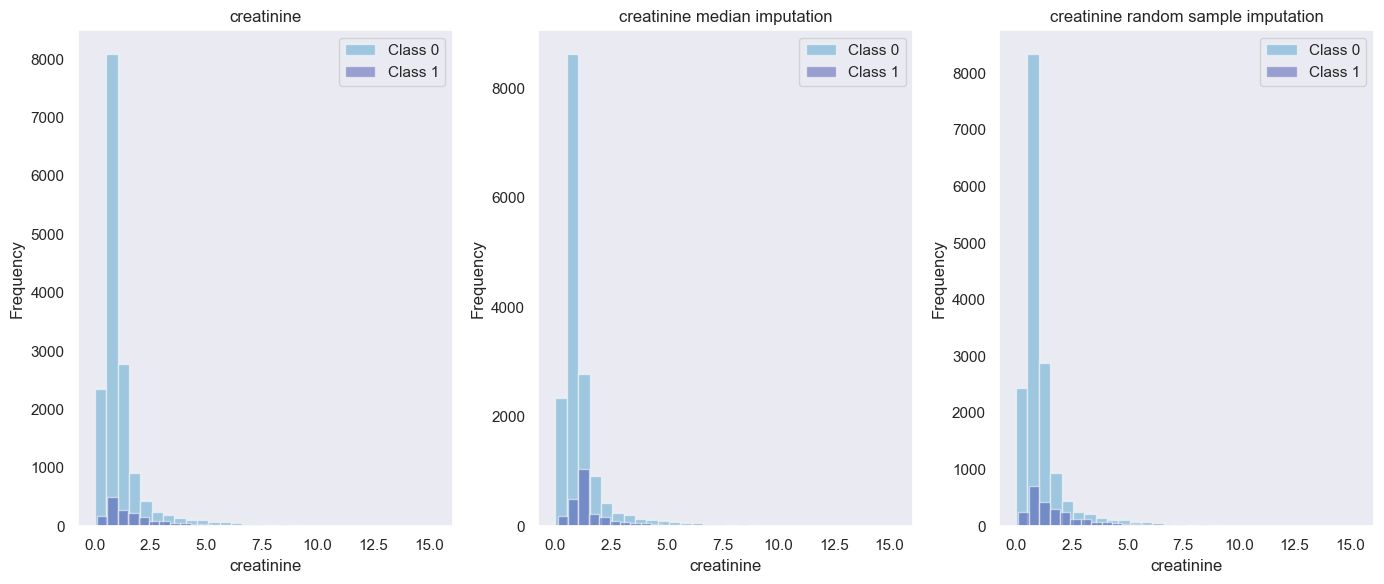

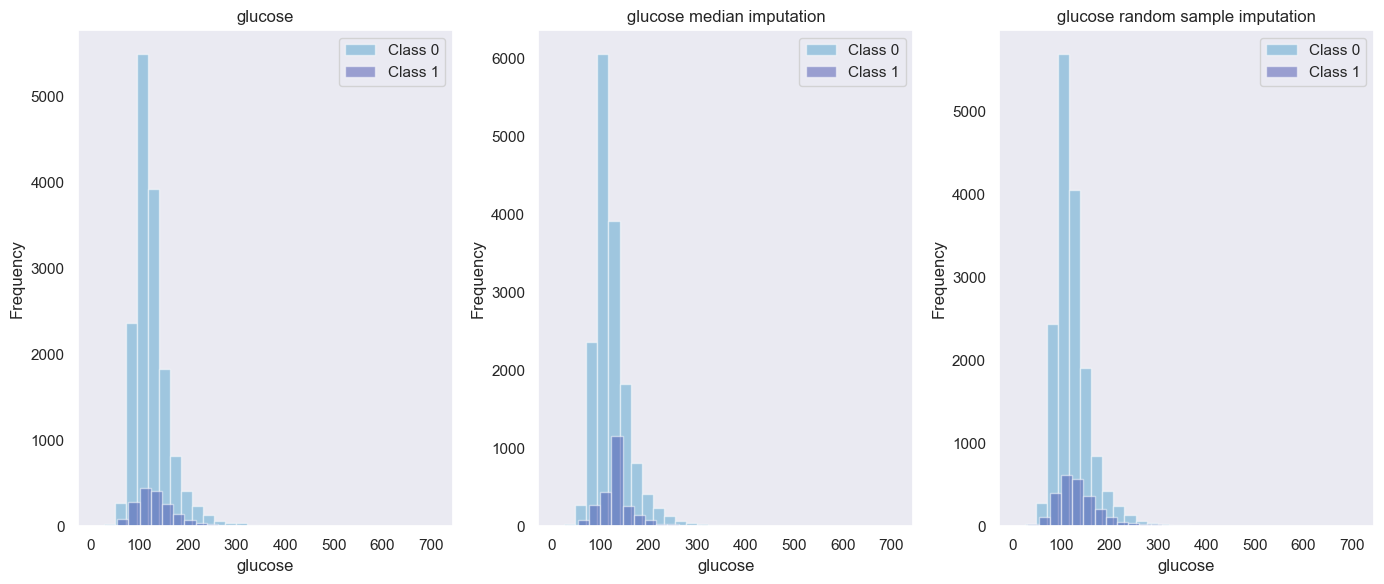

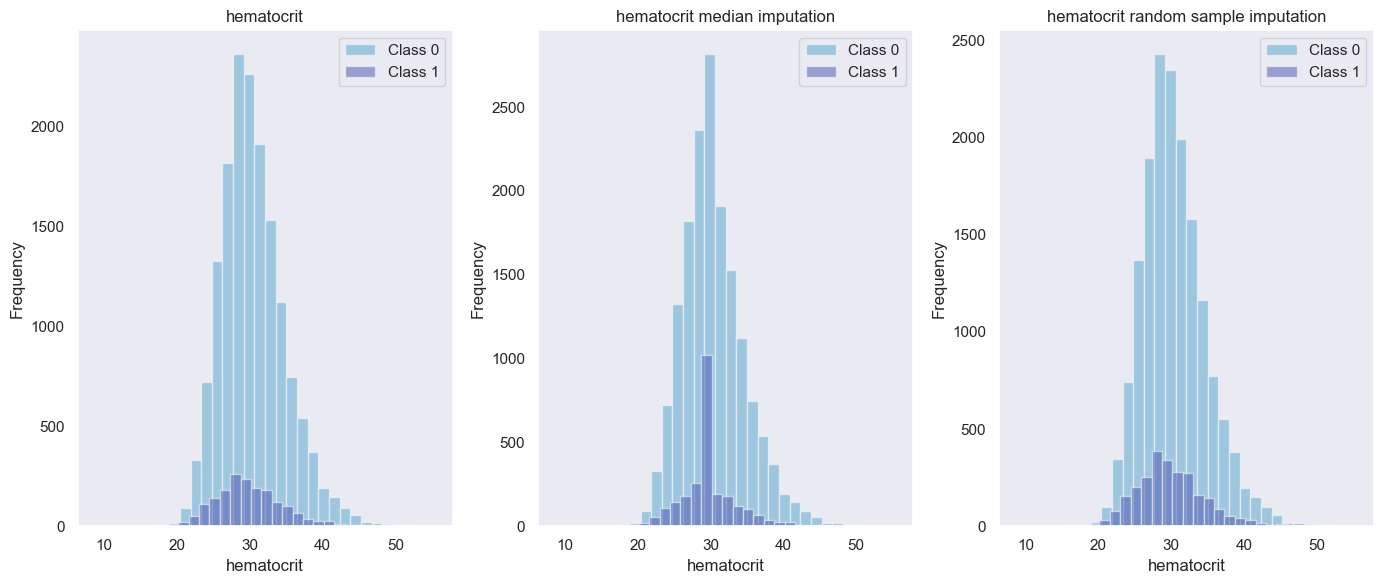

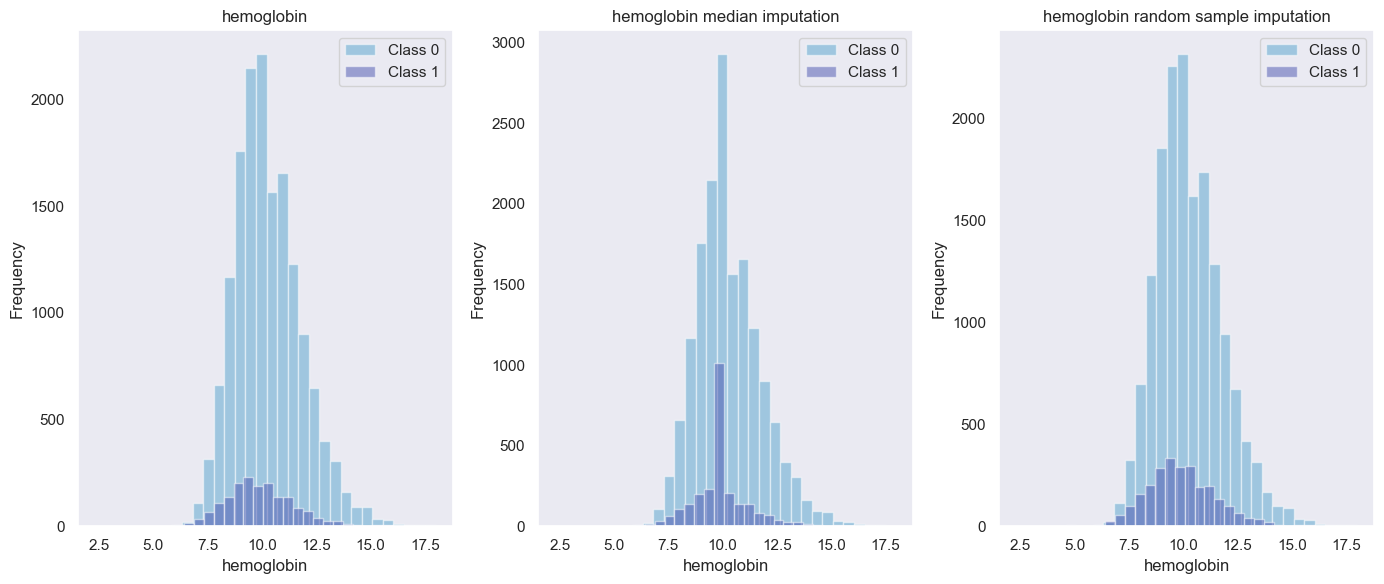

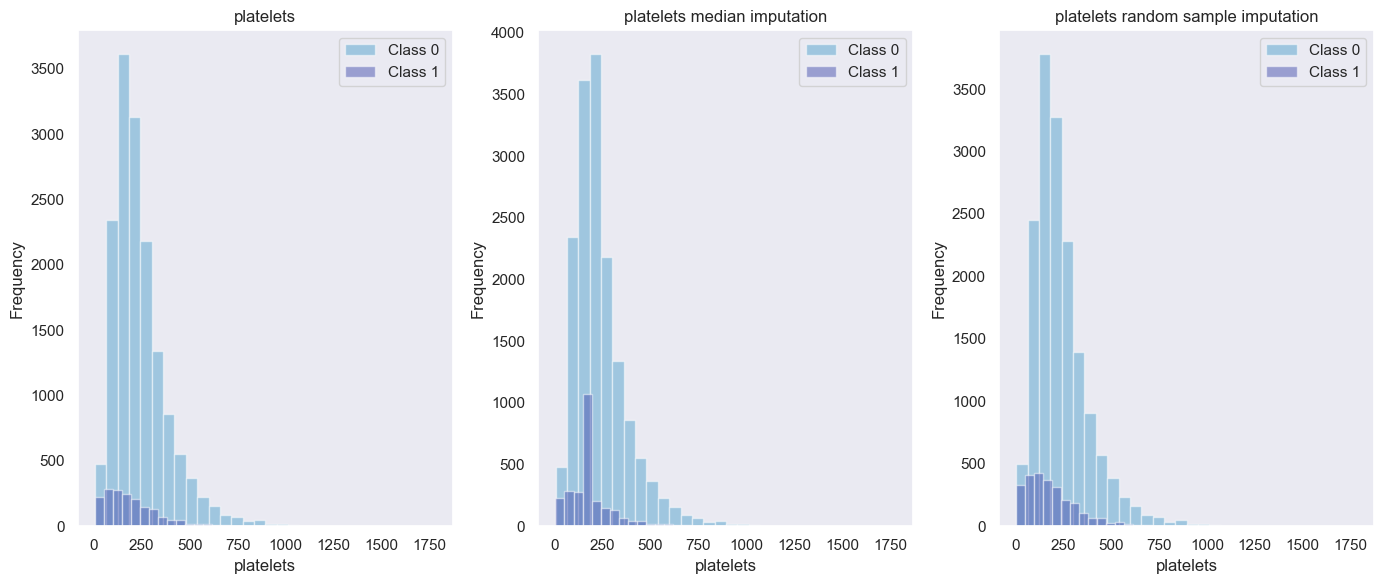

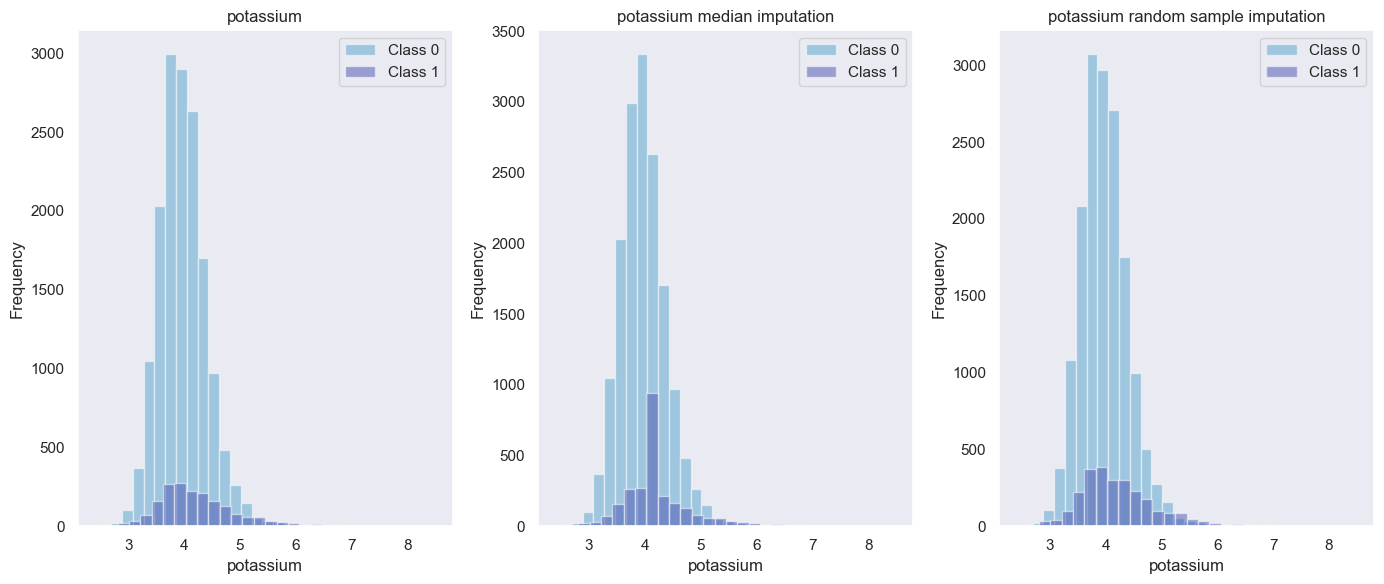

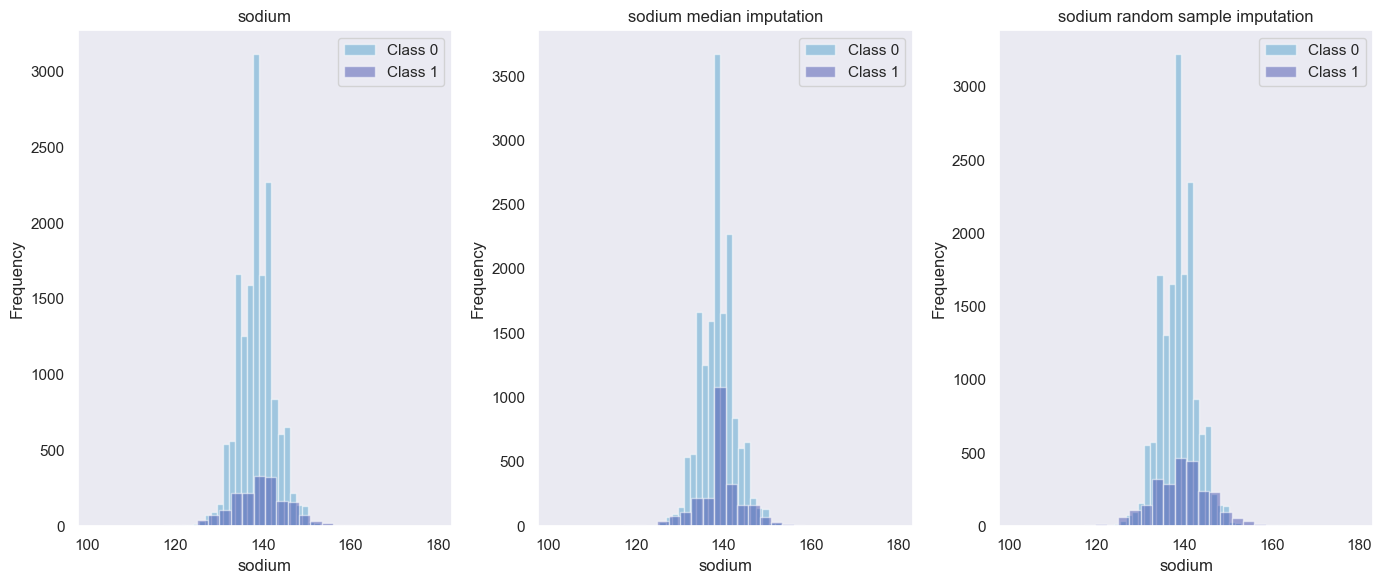

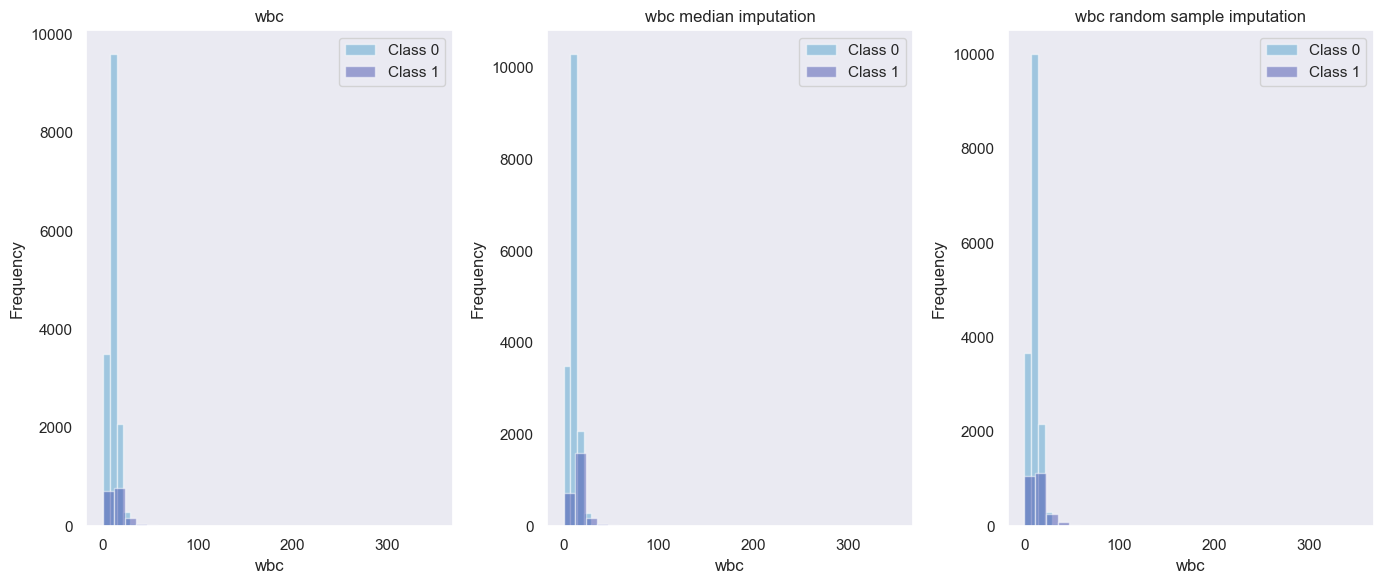

In [34]:
# Plot histograms for each vital sign column before and after imputation
for col in lab_measures2:
    plt.figure(figsize=(14, 6))
    
    # Before imputation
    plt.subplot(1, 3, 1)
    for cls in mimic['death_status'].unique():
        subset = mimic[mimic['death_status'] == cls]
        plt.hist(subset[col].dropna(), alpha=0.5, bins=30, label=f'Class {cls}')
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    
    # After median class-based imputation
    plt.subplot(1, 3, 2)
    for cls in data_imputed_median['death_status'].unique():
        subset = data_imputed_median[data_imputed_median['death_status'] == cls]
        plt.hist(subset[col].dropna(), alpha=0.5, bins=30, label=f'Class {cls}')
    plt.title(f'{col} median imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    
    # After random class-based imputation
    plt.subplot(1, 3, 3)
    for cls in data_imputed_random_class['death_status'].unique():
        subset = data_imputed_random_class[data_imputed_random_class['death_status'] == cls]
        plt.hist(subset[col].dropna(), alpha=0.5, bins=30, label=f'Class {cls}')
    plt.title(f'{col} random sample imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Similar to the imputation in vital signs, the KLD value of random sample imputation is closer to the original KLD value. The KLD value of median imputation significantly differs from the original KLD value. Furthermore, the distribution of the median imputation shows a noticeable spike in the middle due to the imputed median values. Therefore, we use the random sample imputer to fill missing values.

In [35]:
# Initialize the RandomSampleImputer for vital signs
imputer = RandomSampleImputer(variables=lab_measures2, random_state=0)

# Fit the imputer on the data
imputer.fit(mimic_vital_no_null)

# Transform the data
mimic_no_null = imputer.transform(mimic_vital_no_null)

# Display the transformed data to verify missing values have been imputed
mimic_no_null[lab_measures2].isnull().sum()

bun            0
bicarbonate    0
chloride       0
creatinine     0
glucose        0
hematocrit     0
hemoglobin     0
platelets      0
potassium      0
sodium         0
wbc            0
dtype: int64

In [36]:
mimic_no_null.head()

bicarbonate   bun  chloride  creatinine        dbp  glucose  heart_rate  \
0         23.0  17.0      96.0         1.3  55.545455     85.0   92.904762   
1         14.0  73.0     101.0         5.1  64.047619    118.0   85.750000   
2         24.0  33.0     107.0         2.0  76.476190    114.0   81.904762   
3         23.0  29.0     100.0         1.1  75.450000    130.0   94.650000   
4         29.0  13.0     104.0         0.4  60.520000    168.5   99.600000   

   hematocrit  hemoglobin        map  ...  resp_rate      sodium         sbp  \
0        29.6         9.7  75.984845  ...  20.363636  131.500000  116.863636   
1        35.7        12.2  93.873014  ...  14.347826  130.000000  153.523810   
2        36.8        12.6  94.850000  ...  16.653846  135.666667  141.666667   
3        36.6        12.4  99.066730  ...  31.400000  135.000000  146.300000   
4        26.9         8.8  78.533332  ...  18.840000  138.000000  125.440000   

        temp   wbc   age  gender  ethnicity     los death_status  
0  35.930556  10.5  76.0       M      White  6.0646            0  
1  36.039682   3.9  66.0       F      White  3.6729            0  
2  35.888889  11.1  41.0       M      Other  5.3231            1  
3  37.074074  30.2  72.0       M      White  7.6348            1  
4  37.687301  14.3  40.0       F      White  3.6660            0  

[5 rows x 23 columns]

### Outliers

Next, we examine the outliers in the data by first visualizing the numerical data using scatterplots to identify any influential points.

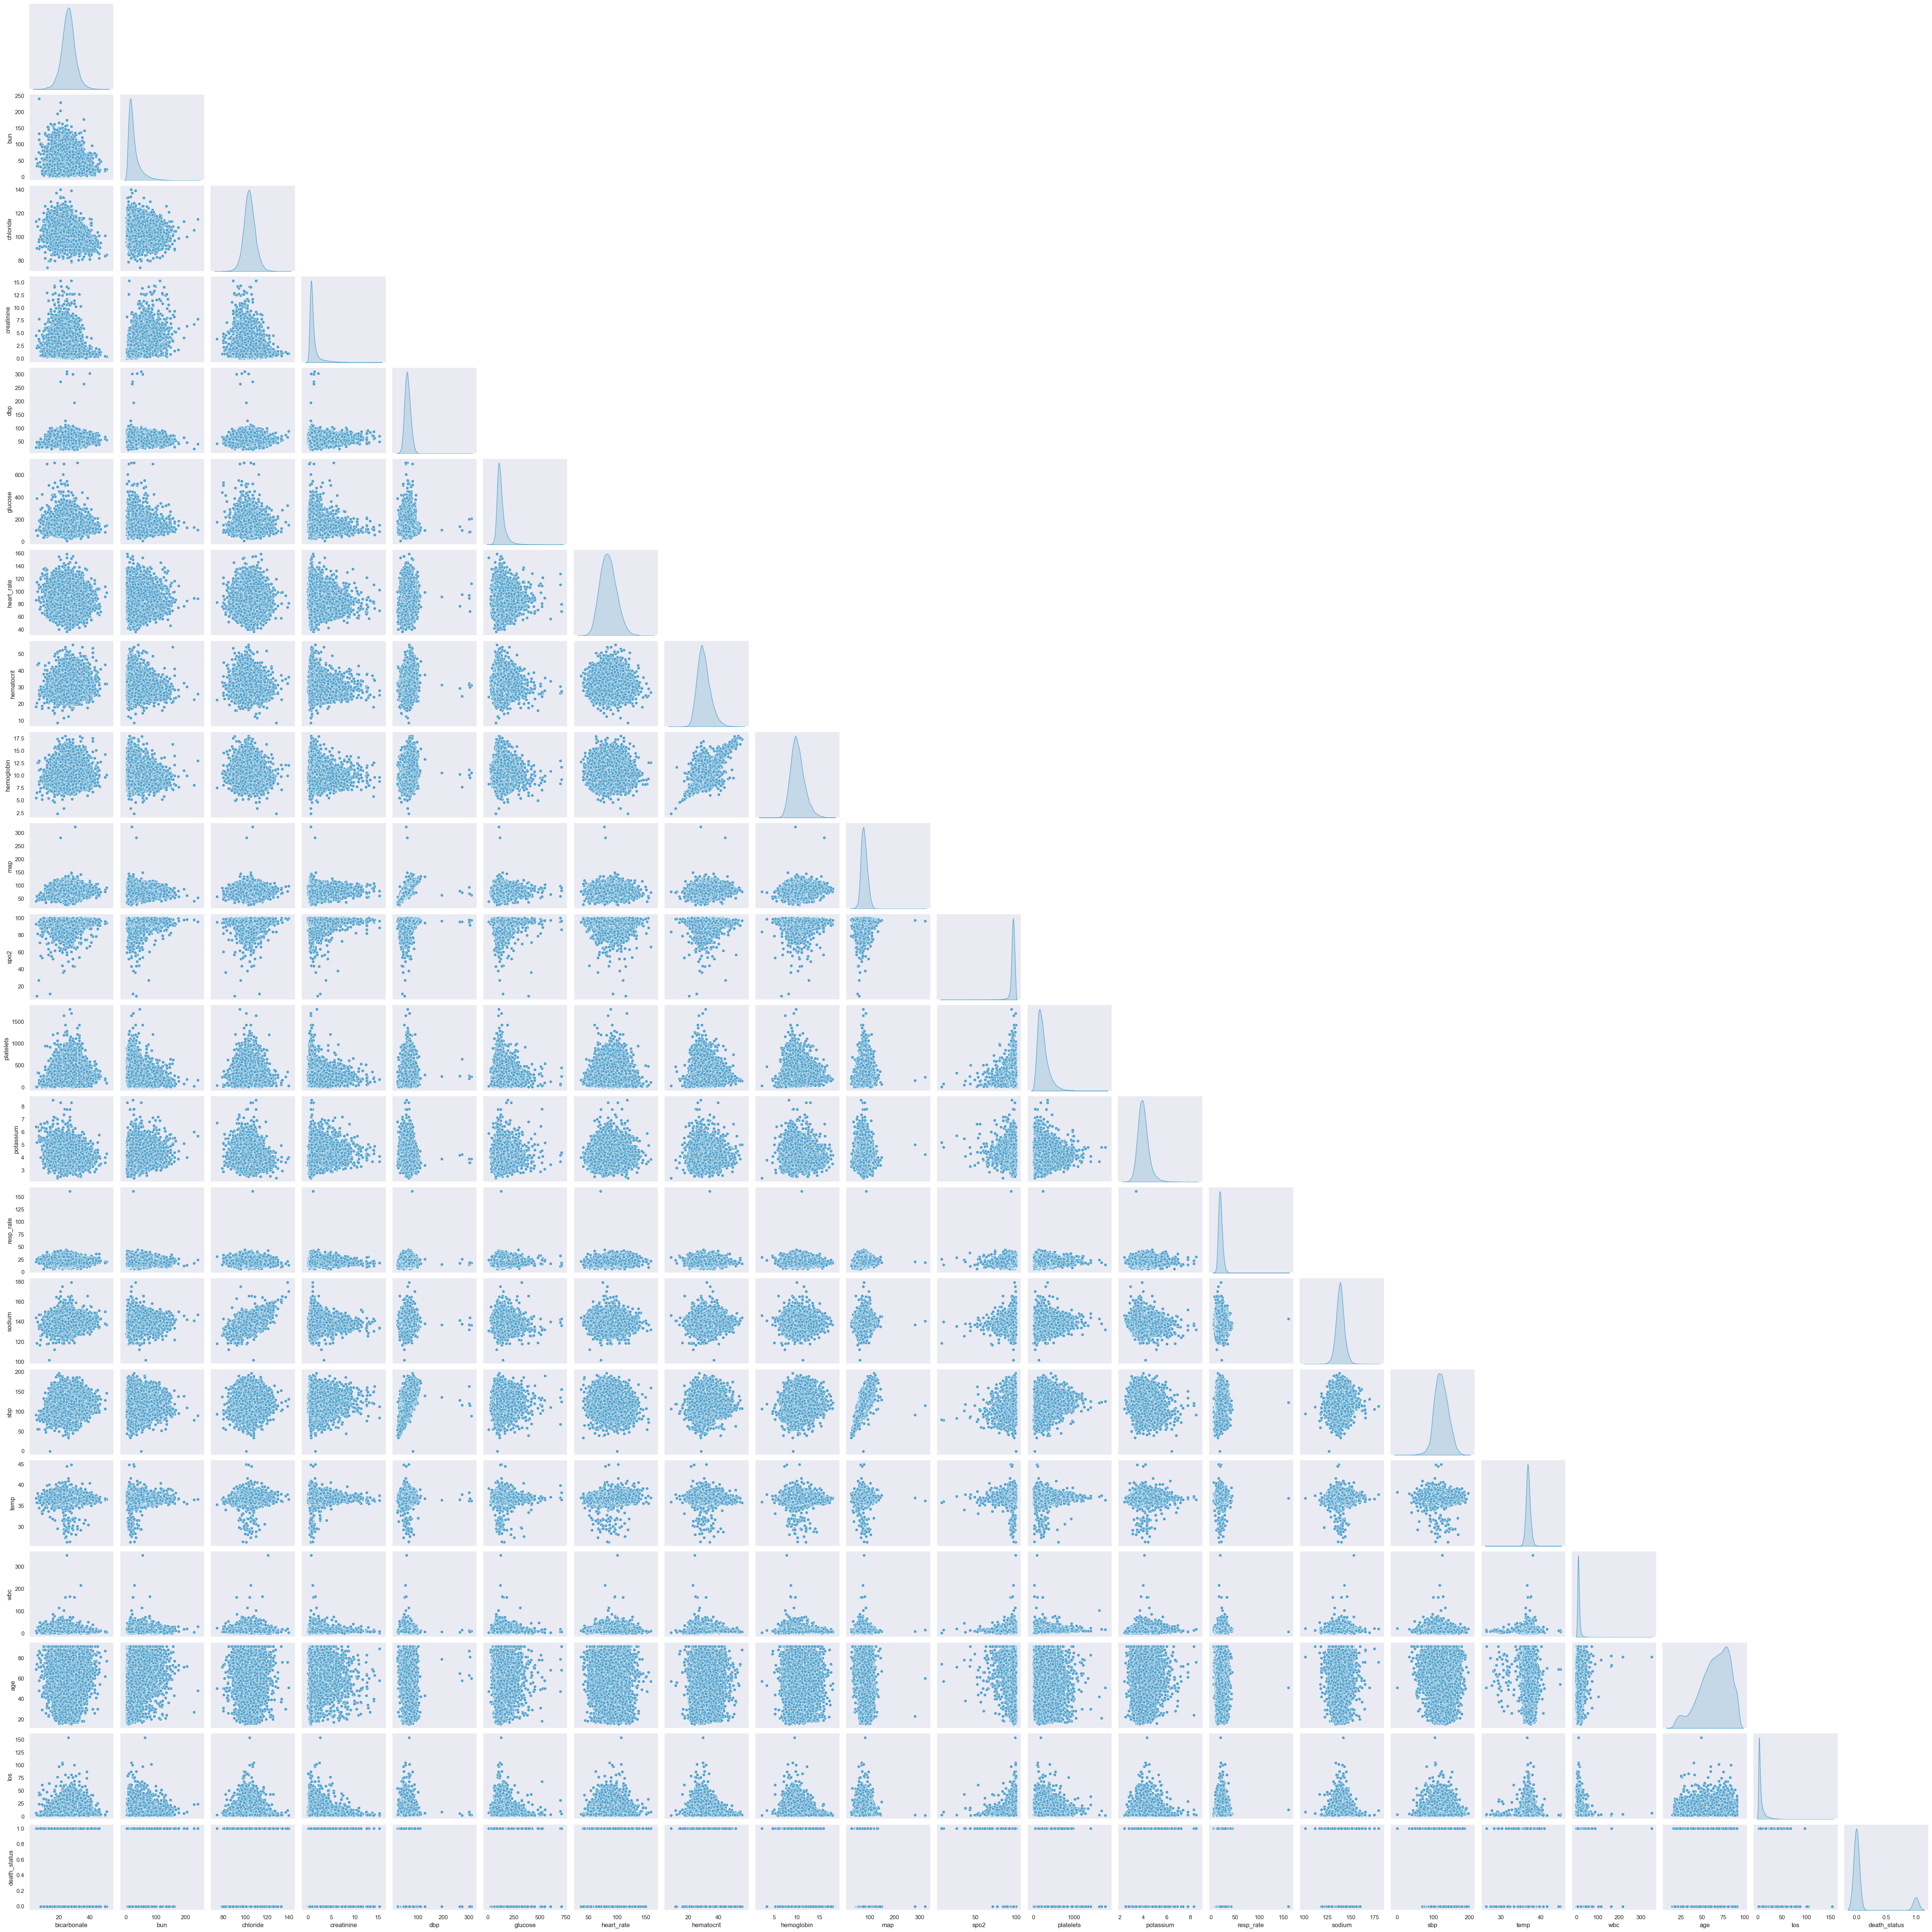

In [37]:
num_features = mimic_no_null.select_dtypes(include=['int64', 'float64']).columns

sns.pairplot(mimic_no_null[num_features], corner=True, diag_kind='kde')

From the scatterplot, we observe the presence of some influential data points. We also observe a linear correlation between some variables: hemoglobin and hematocrit, sodium and chloride, DBP with SBP and MAP, and SBP and MAP.

As we have multivariate data, using typical outlier analysis tools with z-scores and IQR would be inappropriate as they measure in univariate space. Therefore, we will use the Mahalanobis distance to detect outliers. The Mahalanobis distance is a measure of the distance between a point and a distribution; it is particularly useful for identifying outliers in multivariate space as it accounts for correlations among variables. First, we need to standardize the data.

In [38]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

scaler = StandardScaler()

num_features_scaled = scaler.fit_transform(mimic_no_null[num_features])

# Calculate Mahalanobis distance
def calculate_mahalanobis(x, mean, inv_cov_matrix):
    return np.sqrt(mahalanobis(x, mean, inv_cov_matrix))

mean = np.mean(num_features_scaled, axis=0)
cov_matrix = np.cov(num_features_scaled, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

mahalanobis_distances = np.apply_along_axis(calculate_mahalanobis, 1, num_features_scaled, mean, inv_cov_matrix)

# Determine threshold
threshold = chi2.ppf((1 - 0.05), df=num_features_scaled.shape[1])  # 95% confidence interval, df = # of features
outliers = mahalanobis_distances > np.sqrt(threshold) ### threshold is X^2, so sqrt to get threshold of distance

# Remove outliers
mimic_no_outliers = mimic_no_null[~outliers]

print(f"Using the Mahalanobis distance with 95% CI, {mimic_no_null.shape[0]-mimic_no_outliers.shape[0]} outliers were removed.")

Using the Mahalanobis distance with 95% CI, 9 outliers were removed.


Nine data points were outside the 95% Mahalanobis distance and were thus removed. We then explore the collinearity present within the features.

Text(0.5, 1.0, 'Correlation Matrix')

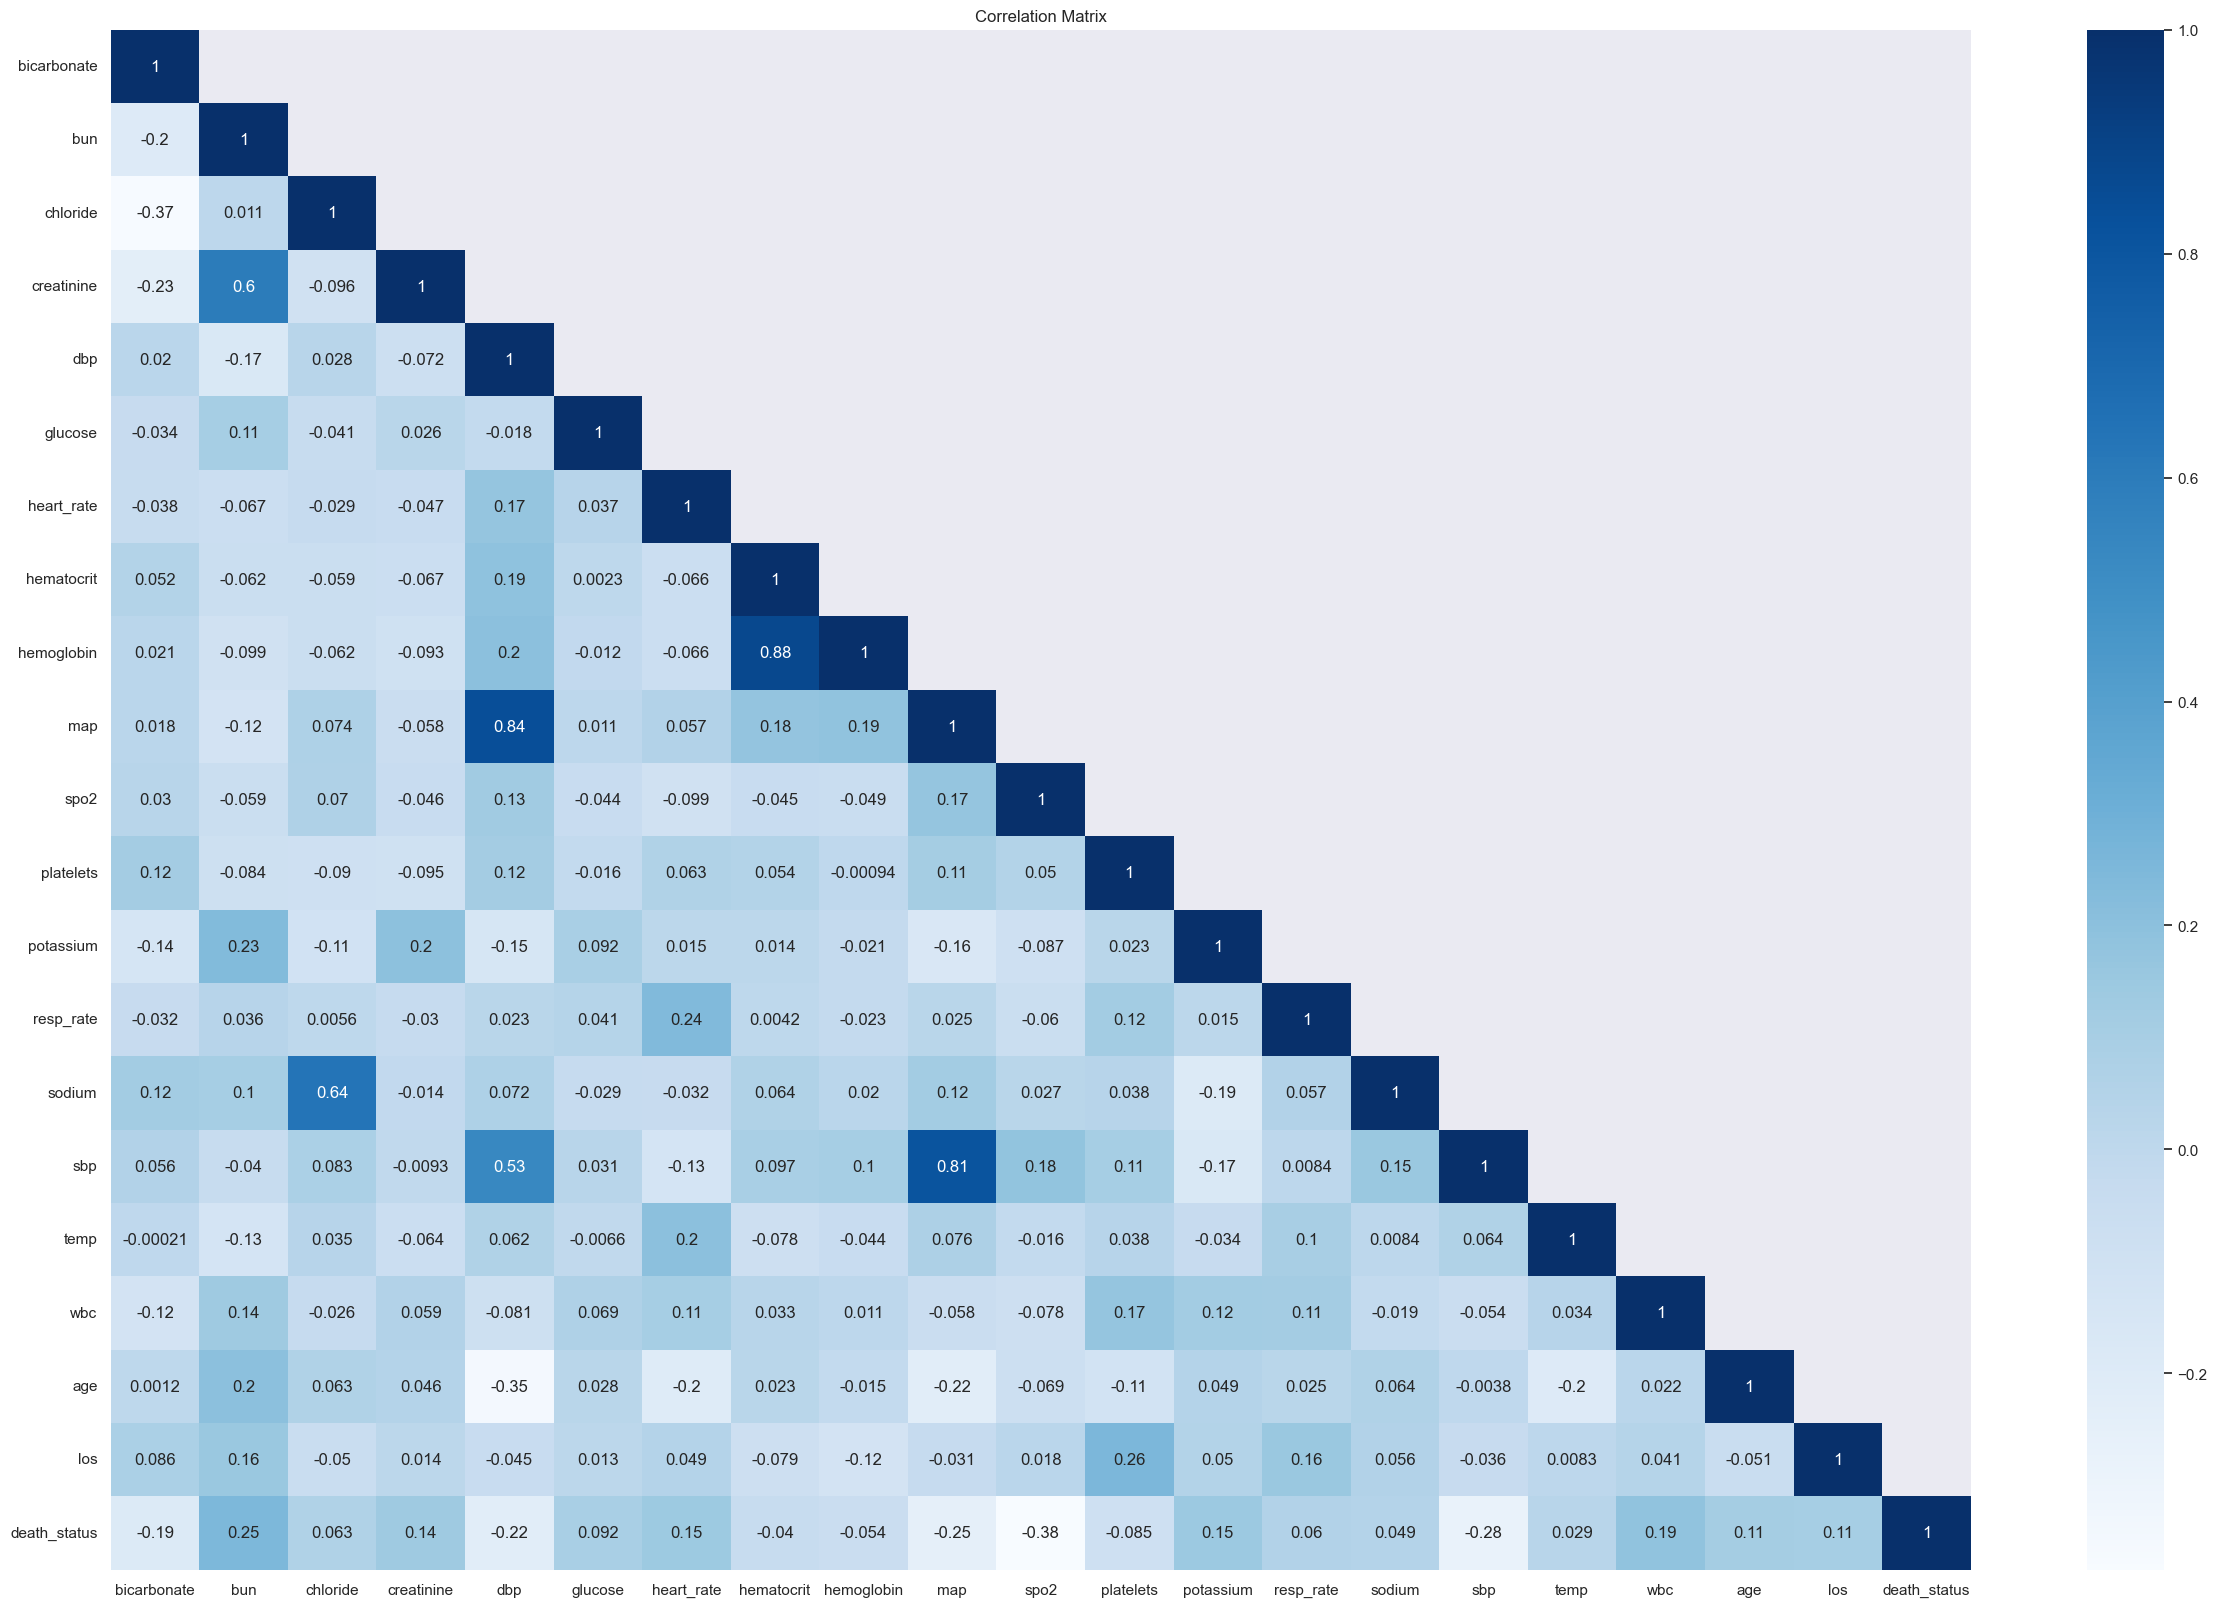

In [39]:
corr_mat = mimic_no_outliers[num_features].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
np.fill_diagonal(mask, False)

plt.figure(figsize=(30, 20))
sns.heatmap(corr_mat, annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')

The correlation matrix shows that hemoglobin and hematocrit, as well as MAP with DBP and SBP, are strongly correlated (correlation > 0.80). There are also some variables with high correlation (0.60-0.80): creatinine and BUN, and sodium and chloride. Additionally, SBP and DBP are moderately correlated (0.53).

In [40]:
mimic_no_outliers.to_csv('mimic_clean.csv', header=True)